
# 23S1-AI6124 Stock Trading Project Assignment
Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 30 Aug 2023

Submitted by: Lu Cheuk Fung Jeff Mat ID: G2304245F

# Instructions
Enter your name according to NTU Learn, and your student ID above. Do not include the square brackets. Please save the file as Project_[Student name].ipynb and submit in NTU Learn.


## Objective

After completing this project, you will know:

Part 1: (Code provided)
* How to download any stock prices to work on
* How to compute buy sell signals on the stock
* How to measure portfolio performance from profit and loss based on buy and sell signals on the stock

Part 2: (To be coded by student)
* How to choose parameters to optimize profits, and explore different trading strategies
* How to apply computational intelligent methods to choose parameters of trading strategies on training data set, then apply to test data set
* How to benchmark the portfolio performance of  computational intelligent methods

Part 3: (To be coded by student)
* How to apply computational intelligent methods to measure the performance of the prediction
* How to interpret and explain the computational intelligent method in predicting the stock prices
* How to apply the stock price prediction to help increase profits, and benchmark the portfolio performance with and without prediction

Code for part 1 of first 3 objectives listed above are provide for you to kick start your project. You will have to complete part 2 and part 3 for the project.


## Reference

Ang, K. K., & Quek, C. (2006). Stock Trading Using RSPOP: A Novel Rough Set-Based Neuro-Fuzzy Approach. IEEE Trans. Neural Netw., 17(5), 1301-1315. doi:http://dx.doi.org/10.1109/TNN.2006.875996

## Introduction

First we install the yahoo finance library

This library is used to download stock prices into pandas data frame.

In [61]:
# !pip install pandas
# !pip install yfinance
# !pip install yahoofinancials
# !pip install mpld3


Then we import the necessary libraries

In [62]:
import math

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from copy import deepcopy as dc
import torch
from windowFrameLoader import load_window_frame_dataset
from sklearn import preprocessing

In [63]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# 1. Stock prices

Pick a Singapore trust stock price to download. Do not pick just any stocks. An example is Real Estate Investment Trust (REIT). You will need the symbol, such as Keppel REIT (K71U.SI). You can look up the symbol from https://sg.finance.yahoo.com/lookup. The following is how you can download the historical prices of a REIT.

In [64]:
stock_df = yf.download('A17U.SI')# K71U.SI
stock_df.head()

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2005-09-30  2.176150  2.176150  2.136939  2.146744   0.730816  5001041
2005-10-03  2.136939  2.146744  2.117339  2.127144   0.724144  3696959
2005-10-04  2.127144  2.127144  2.107534  2.117339   0.720805  2252786
2005-10-05  2.117339  2.117339  2.078128  2.078128   0.707457  3284927
2005-10-06  2.068323  2.078128  2.029112  2.038918   0.694109  5603638

Alternatively, you can also use the ticker function to download the stock price. Ticker also allows you to download additional data. After you downloaded the stock price, you can also plot the data.

<Axes: title={'center': 'CapitaLand Ascendas REIT'}, xlabel='Date'>

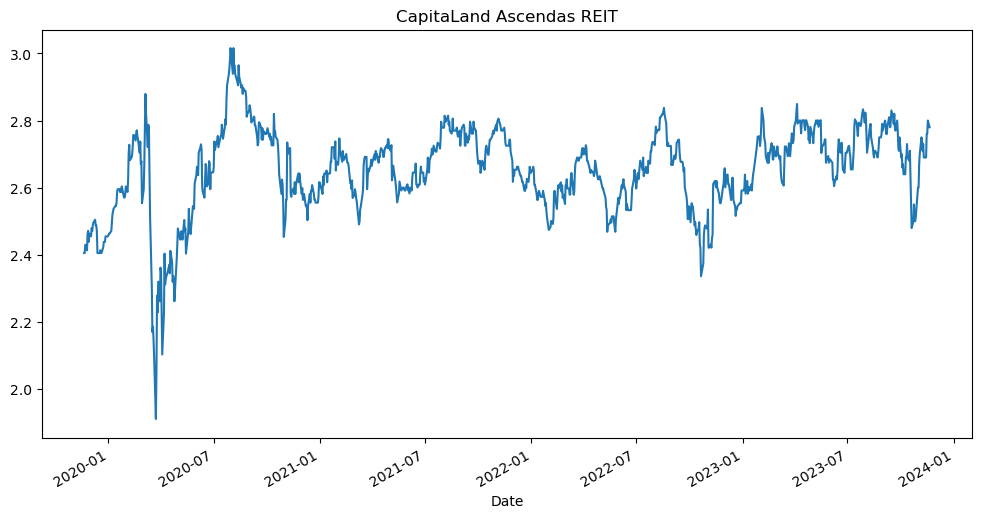

In [65]:
ticker = yf.Ticker('A17U.SI')
stock_df = ticker.history(period="4y") # max
figure(figsize=(12, 6))
stock_df['Close'].plot(title="CapitaLand Ascendas REIT")

In [66]:
stock_df.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2019-11-20 00:00:00+08:00  2.413661  2.421927  2.388863  2.405395  16620800   
2019-11-21 00:00:00+08:00  2.388863  2.413661  2.380597  2.405395  16277300   
2019-11-22 00:00:00+08:00  2.397129  2.430193  2.388863  2.430193  14574100   
2019-11-25 00:00:00+08:00  2.438459  2.446725  2.405395  2.413661  12035600   
2019-11-26 00:00:00+08:00  2.430193  2.463257  2.413661  2.463257  24725800   

                           Dividends  Stock Splits  
Date                                                
2019-11-20 00:00:00+08:00        0.0           0.0  
2019-11-21 00:00:00+08:00        0.0           0.0  
2019-11-22 00:00:00+08:00        0.0           0.0  
2019-11-25 00:00:00+08:00        0.0           0.0  
2019-11-26 00:00:00+08:00        0.0           0.0

# 2. Computing trade signals

There are different types of moving averages, such as simple moving average, weighted moving average or exponential moving average. The
difference between the types is how the average is computed based on the weight assigned to data points. Simple moving average can be computed by simply taking the mean of the data points. The period to compute the moving average is a parameter. You can have a 200 days simple moving average, a 5 days simple moving average etc. Here' we compute a fast 20 days and slow 100 days moving average on the close price.

In [67]:
df=stock_df
# create 20 days simple moving average column
df['Fast_SMA'] = df['Close'].rolling(window = 20, min_periods = 1).mean()
# create 50 days simple moving average column
df['Slow_SMA'] = df['Close'].rolling(window = 100, min_periods = 1).mean()
# display first few rows
df.head()

Open      High       Low     Close    Volume  \
Date                                                                          
2019-11-20 00:00:00+08:00  2.413661  2.421927  2.388863  2.405395  16620800   
2019-11-21 00:00:00+08:00  2.388863  2.413661  2.380597  2.405395  16277300   
2019-11-22 00:00:00+08:00  2.397129  2.430193  2.388863  2.430193  14574100   
2019-11-25 00:00:00+08:00  2.438459  2.446725  2.405395  2.413661  12035600   
2019-11-26 00:00:00+08:00  2.430193  2.463257  2.413661  2.463257  24725800   

                           Dividends  Stock Splits  Fast_SMA  Slow_SMA  
Date                                                                    
2019-11-20 00:00:00+08:00        0.0           0.0  2.405395  2.405395  
2019-11-21 00:00:00+08:00        0.0           0.0  2.405395  2.405395  
2019-11-22 00:00:00+08:00        0.0           0.0  2.413661  2.413661  
2019-11-25 00:00:00+08:00        0.0           0.0  2.413661  2.413661  
2019-11-26 00:00:00+08:00        0.0           0.0  2.423580  2.423580

There many moving average strategies that can be developed to generate trade signals. here we will use a simple moving average crossover strategy based on the SMAs we computed. A moving average can be use to indicate price trends. A crossover occurs when a faster or shorter moving average, such as the 20 days SMA crosses a slower or longer moving average, such as the 100 days SMA. This crossover  point can be used as a  indicator to buy or sell a stock.

First we create a new column ‘Signal’ such that if Fast_SMA is greater than Slow_SMA then set to 1 else set to 0.


In [68]:
df['Signal'] = 0.0
df['Signal'] = np.where(df['Fast_SMA'] > df['Slow_SMA'], 1.0, 0.0)

We now need to generate the buy and sell from the ‘Signal’ values. Crossover happens when the Fast_SMA and the Slow_SMA cross,  the ‘Signal’ changes from 0 to 1, or from 1 to 0. Thus we can just create a ‘Position’ value to indicate a day-to-day difference of the ‘Signal’ column.

‘Position’ = 1 implies that Signal changed from 0 to 1, meaning a faster moving average has crossed a slower moving average. This indicates a bull or up trend in the price and thus this is a buy signal.

‘Position’ = -1 implies that  Signal changed from 1 to 0, meaning a faster moving average has crossed below a slower moving average. This indicates a bear or down trend in the price and thus this is a sell signal.

In [69]:
df['Position'] = df['Signal'].diff()
# Need to set the first row of Position to 0. Otherwise it is nan from diff function.
df['Position'].iloc[0]=0
# display first few rows
df.head()


C:\Users\jeffl\AppData\Local\Temp\ipykernel_18588\2141737872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'].iloc[0]=0


Open      High       Low     Close    Volume  \
Date                                                                          
2019-11-20 00:00:00+08:00  2.413661  2.421927  2.388863  2.405395  16620800   
2019-11-21 00:00:00+08:00  2.388863  2.413661  2.380597  2.405395  16277300   
2019-11-22 00:00:00+08:00  2.397129  2.430193  2.388863  2.430193  14574100   
2019-11-25 00:00:00+08:00  2.438459  2.446725  2.405395  2.413661  12035600   
2019-11-26 00:00:00+08:00  2.430193  2.463257  2.413661  2.463257  24725800   

                           Dividends  Stock Splits  Fast_SMA  Slow_SMA  \
Date                                                                     
2019-11-20 00:00:00+08:00        0.0           0.0  2.405395  2.405395   
2019-11-21 00:00:00+08:00        0.0           0.0  2.405395  2.405395   
2019-11-22 00:00:00+08:00        0.0           0.0  2.413661  2.413661   
2019-11-25 00:00:00+08:00        0.0           0.0  2.413661  2.413661   
2019-11-26 00:00:00+08:00        0.0           0.0  2.423580  2.423580   

                           Signal  Position  
Date                                         
2019-11-20 00:00:00+08:00     0.0       0.0  
2019-11-21 00:00:00+08:00     0.0       0.0  
2019-11-22 00:00:00+08:00     0.0       0.0  
2019-11-25 00:00:00+08:00     0.0       0.0  
2019-11-26 00:00:00+08:00     0.0       0.0

<Axes: xlabel='Date'>

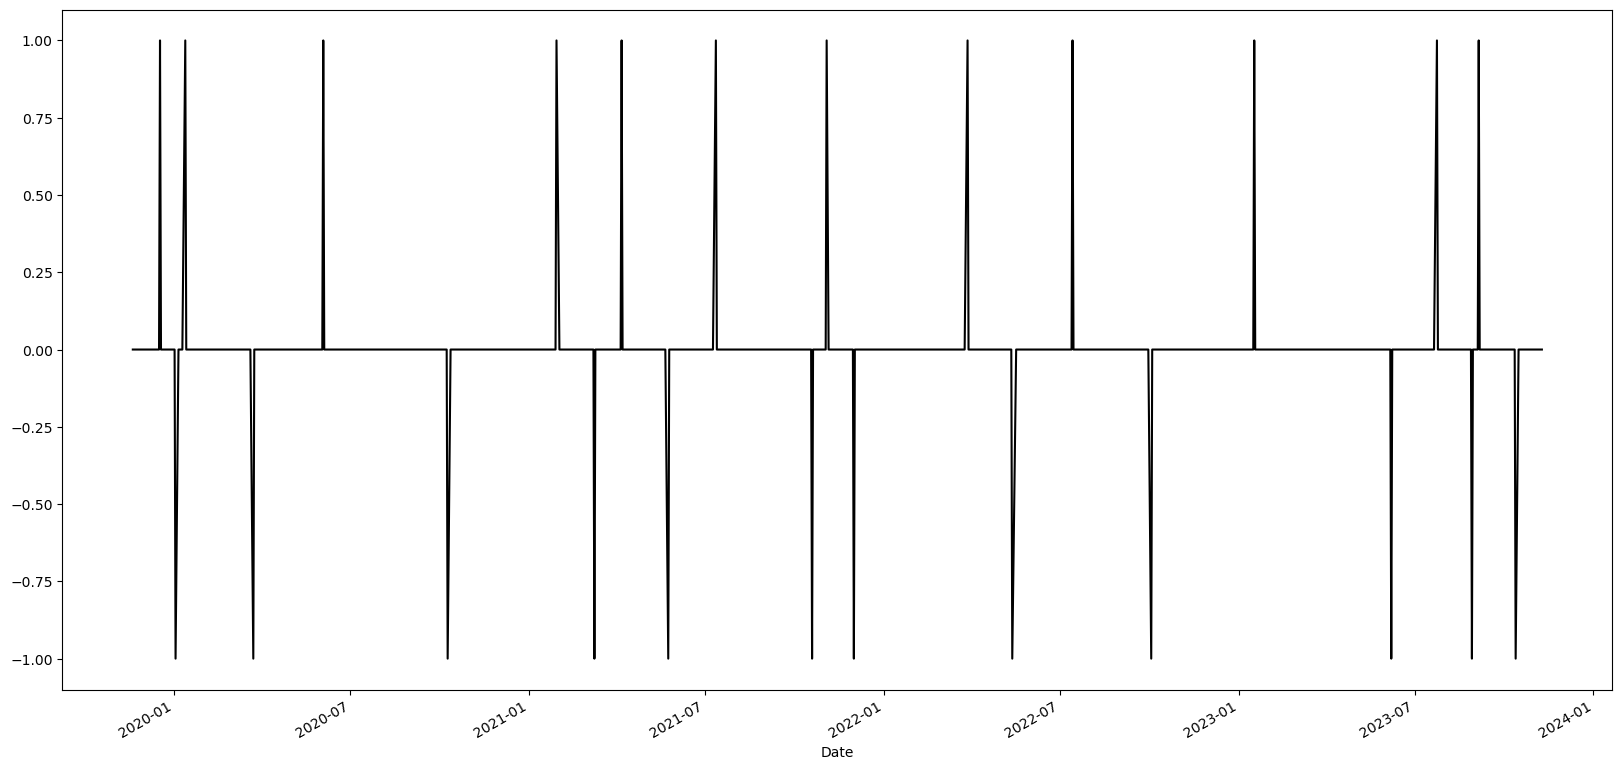

In [70]:
# Plot the positions
plt.figure(figsize = (20,10))
df.iloc[0:1000]['Position'].plot(color = 'k', label= 'Position')


Next we need to change the position signal to trade signals. Although position can give us this information, we want the change in the trade signal, which is the change from -1 to 1 to indicate a buy, and 1 to -1 to indicate a sell. This is for computing the Multiplicative Portfolio Returns.

0.0


<Axes: xlabel='Date'>

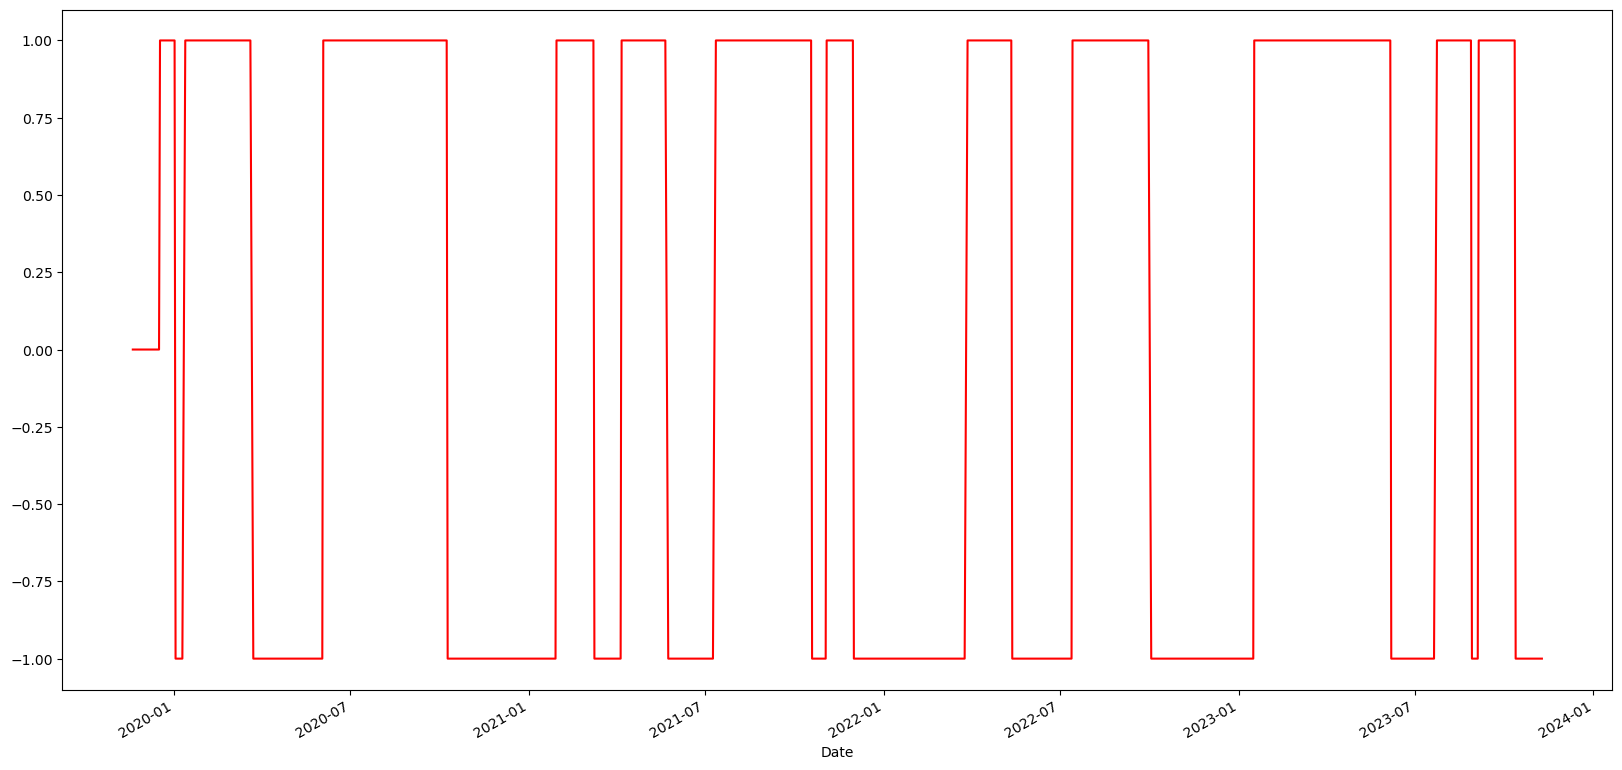

In [71]:
plt.figure(figsize = (20,10))
df['Trade'] = df['Position']
prevrow = df.iloc[0]
print(prevrow['Position'])
for index, row in df.iloc[1:].iterrows():
  if row['Trade']==0:
    if prevrow['Trade']!=0:
      df.at[index,'Trade']=prevrow['Trade']
      row['Trade']=prevrow['Trade']
  prevrow=row
df.iloc[0:1000]['Trade'].plot(color = 'r', label= 'Trade')

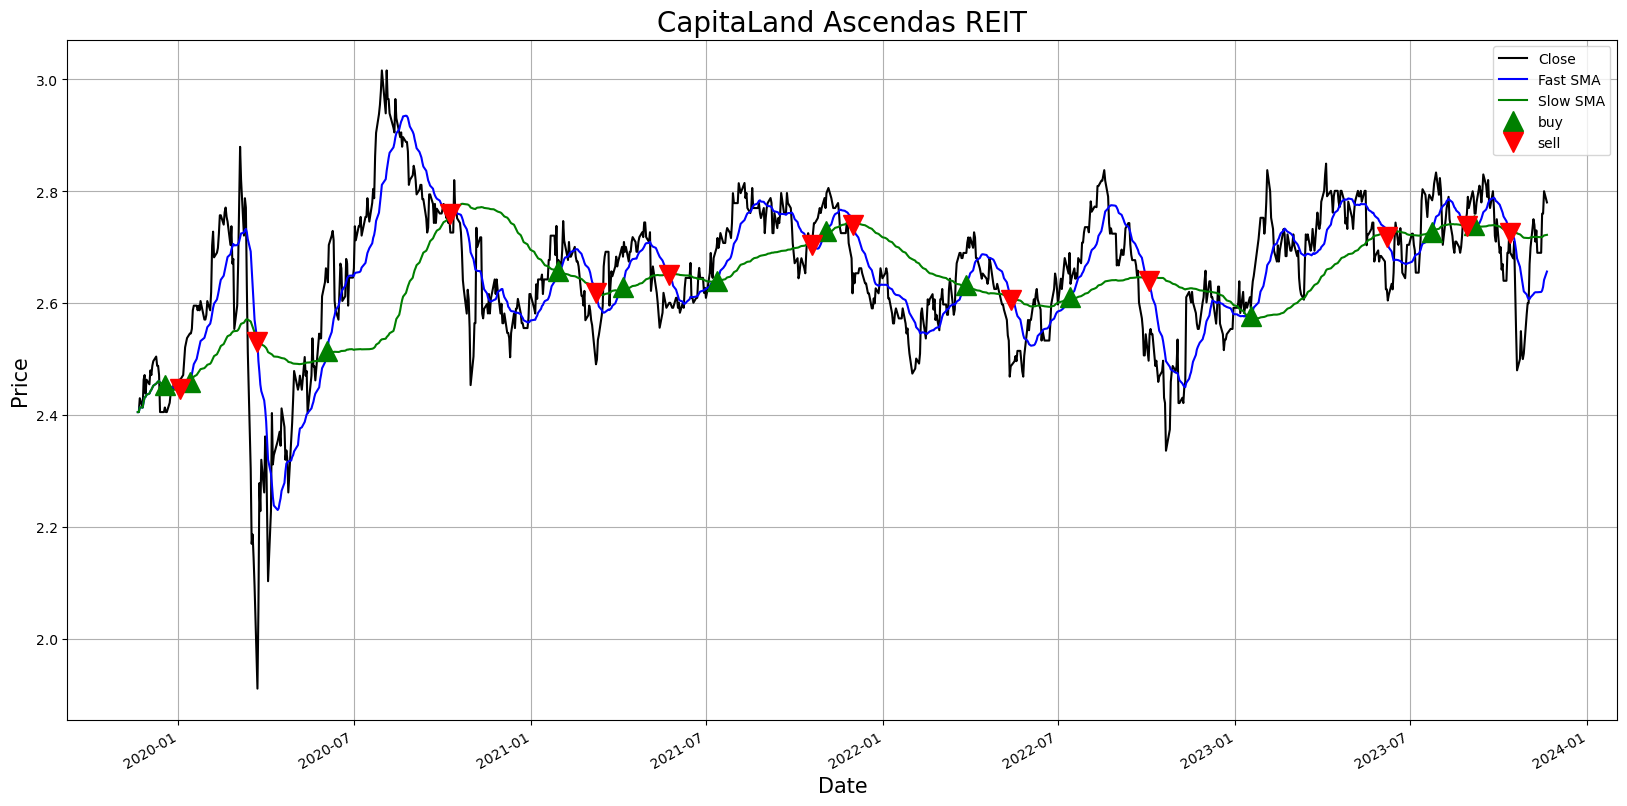

In [72]:
# plot close price, Fast and Slow simple moving averages
def plotprice(df):
  plt.figure(figsize = (20,10))
  df['Close'].plot(color = 'k', label= 'Close')
  df['Fast_SMA'].plot(color = 'b', label = 'Fast SMA')
  df['Slow_SMA'].plot(color = 'g', label = 'Slow SMA')
  # plot buy signals
  plt.plot(df[df['Position'] == 1].index, df['Fast_SMA'][df['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
  # plot sell signals
  plt.plot(df[df['Position'] == -1].index, df['Fast_SMA'][df['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')
  plt.ylabel('Price', fontsize = 15 )
  plt.xlabel('Date', fontsize = 15 )
  plt.title('CapitaLand Ascendas REIT', fontsize = 20)
  plt.legend()
  plt.grid()
  plt.show()

plotprice(df)

It is not very clear in the plot above since it included the prices of many years. Lets zoom in to take a closer look.

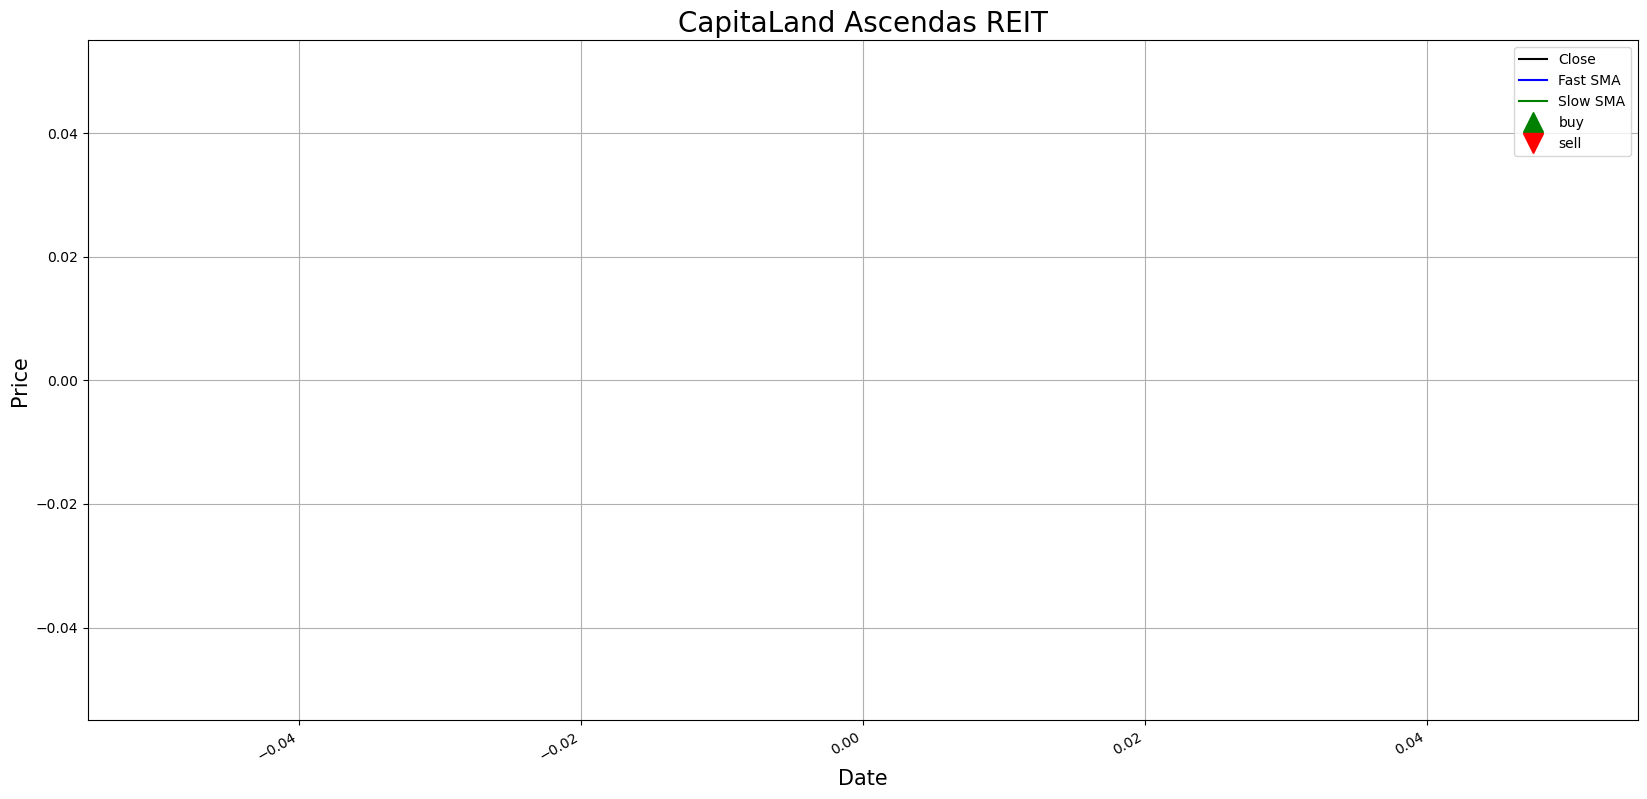

In [73]:
sdf=df.loc['2009-01-01':'2010-12-31']
plotprice(sdf)


Notice that there is a buy at Apr 2009, but the buy and sell are performed at almost the same price at around May 2010. Since each trade incurs a transaction cost, trades at around the same price will result in losses. Hence a better trading strategy can be implemented, such as the introduction of a moving average band to reduce the number of trades around the same price. Refer to the paper on this for more details.

# 3. Computing portfolio returns

The computation of portfolio returns in this section is based on the multiplicative returns given by (refer equation 11 of the reference paper)

$\begin{equation}
R(T)=\{1+F(T-1)r(T)\}\{1-\delta|F(T)-F(T-1)|\}
\end{equation}$

where $r(T)=(y(T)/y(T-1))-1$; $y(T)$ is the closing price at time $T$; $F(T)$ is the action from the trading system; and $\delta$ is the transaction rate.

The multplicative profits $R$ can computed using

$\begin{equation}
R=\prod\limits_{T = 1}^{n} R(T)
\end{equation}$

where $n$ is the total number of time points.


0.0


<Axes: xlabel='Date'>

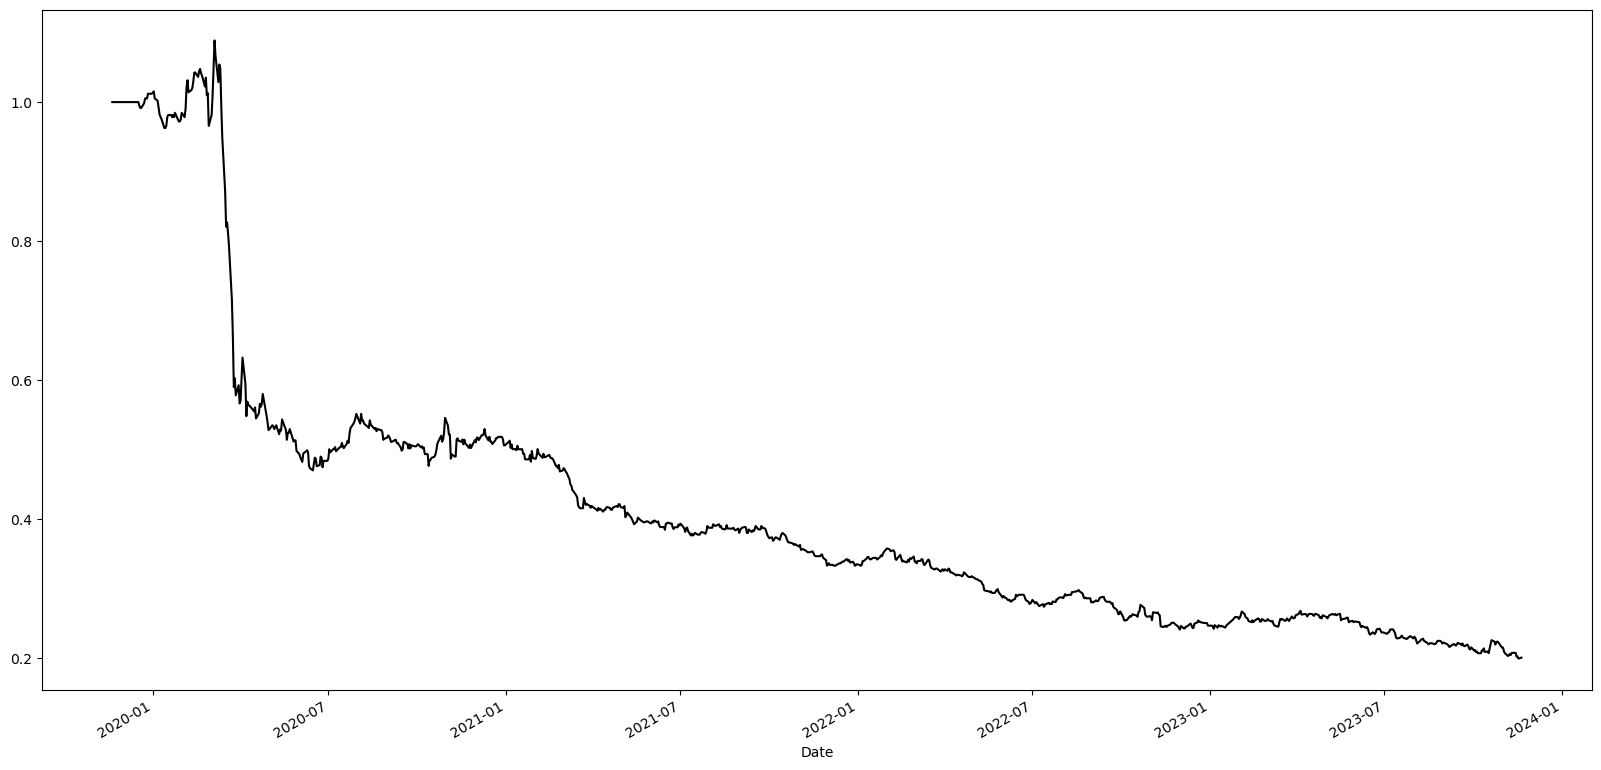

In [74]:
df['Returns']=1.0
print(df.iloc[1]['Trade'])

def computereturns(tdf,trate):
  prevrow = tdf.iloc[0]
  returncol=tdf.columns.get_loc('Returns')
  for i in range(len(tdf)):
    if i==0:
      prev_i=i
    else:
      prevrow=tdf.iloc[prev_i]
      row=tdf.iloc[i]
      rt=(row['Close']/prevrow['Close'])-1
      t=prevrow['Returns']*(1+prevrow['Trade']*rt)*(1-trate*abs(row['Trade']-prevrow['Trade']))
      tdf.iat[i,returncol]=t
      prev_i=i
  return tdf

df=computereturns(df,0.005)
plt.figure(figsize = (20,10))
#df.iloc[1:1000]['Returns'].plot(color = 'k', label= 'Returns')
df['Returns'].plot(color = 'k', label= 'Returns')


Notice in the above plot that some times the portfolio returns dropped below 1.0, some times it rises above 2.0. Hence this shows that the choice of trading strategy and parameters are very important to yield either profits or losses. Above 1.0 indicates there is overall profit. Less than 1.0 indicates there is a loss.


## Data preprocessing

In [75]:
close = df["Close"]
close = pd.DataFrame(close)
close.head()

Close
Date                               
2019-11-20 00:00:00+08:00  2.405395
2019-11-21 00:00:00+08:00  2.405395
2019-11-22 00:00:00+08:00  2.430193
2019-11-25 00:00:00+08:00  2.413661
2019-11-26 00:00:00+08:00  2.463257

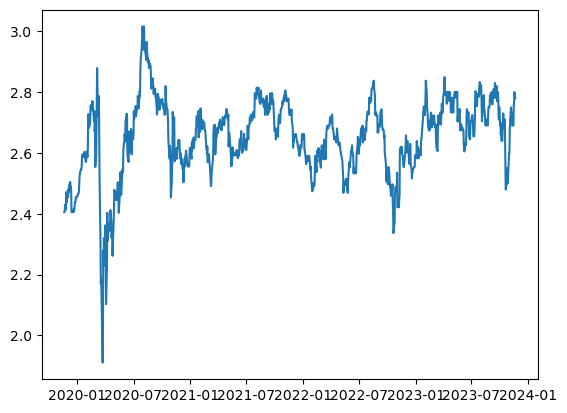

In [76]:
plt.plot(close.index, close)

In [77]:
def prepare_dataset(dataframe, col_name, frame_size=20):
  dataframe = dc(dataframe)
  for i in range(1, frame_size):
    dataframe[f'{col_name}(t-{i})'] = dataframe[f'{col_name}'].shift(i)
  dataframe.dropna(inplace=True)
  return dataframe

def subtraction(dataframe):
  dataframe = prepare_dataset(dataframe, 'Close', frame_size=2)
  dataframe['difference'] = dataframe['Close'] - dataframe['Close(t-1)']
  dataframe.dropna(inplace=True)
  return dataframe

# change window to Change the time shift window size
window = 40 # 31
# close_frame = subtraction(close)
# close_frame = pd.DataFrame(close_frame['difference'])

close_value = close.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
close_value = min_max_scaler.fit_transform(close_value)
close['Close'] = close_value

# close_frame = prepare_dataset(close_frame, 'difference', frame_size=window)
# close_frame.head()

close_frame = prepare_dataset(close, 'Close', frame_size=window)
close_frame.head()

Close  Close(t-1)  Close(t-2)  Close(t-3)  \
Date                                                                      
2020-01-15 00:00:00+08:00  0.582069    0.574586    0.574586    0.567104   
2020-01-16 00:00:00+08:00  0.612001    0.582069    0.574586    0.574586   
2020-01-17 00:00:00+08:00  0.619484    0.612001    0.582069    0.574586   
2020-01-20 00:00:00+08:00  0.619484    0.619484    0.612001    0.582069   
2020-01-21 00:00:00+08:00  0.612001    0.619484    0.619484    0.612001   

                           Close(t-4)  Close(t-5)  Close(t-6)  Close(t-7)  \
Date                                                                        
2020-01-15 00:00:00+08:00    0.559620    0.552138    0.529689    0.507241   
2020-01-16 00:00:00+08:00    0.567104    0.559620    0.552138    0.529689   
2020-01-17 00:00:00+08:00    0.574586    0.567104    0.559620    0.552138   
2020-01-20 00:00:00+08:00    0.574586    0.574586    0.567104    0.559620   
2020-01-21 00:00:00+08:00    0.582069    0.574586    0.574586    0.567104   

                           Close(t-8)  Close(t-9)  ...  Close(t-30)  \
Date                                               ...                
2020-01-15 00:00:00+08:00    0.499757    0.499757  ...     0.514723   
2020-01-16 00:00:00+08:00    0.507241    0.499757  ...     0.507241   
2020-01-17 00:00:00+08:00    0.529689    0.507241  ...     0.522206   
2020-01-20 00:00:00+08:00    0.552138    0.529689  ...     0.529689   
2020-01-21 00:00:00+08:00    0.559620    0.552138  ...     0.537172   

                           Close(t-31)  Close(t-32)  Close(t-33)  Close(t-34)  \
Date                                                                            
2020-01-15 00:00:00+08:00     0.492274     0.499757     0.477309     0.507241   
2020-01-16 00:00:00+08:00     0.514723     0.492274     0.499757     0.477309   
2020-01-17 00:00:00+08:00     0.507241     0.514723     0.492274     0.499757   
2020-01-20 00:00:00+08:00     0.522206     0.507241     0.514723     0.492274   
2020-01-21 00:00:00+08:00     0.529689     0.522206     0.507241     0.514723   

                           Close(t-35)  Close(t-36)  Close(t-37)  Close(t-38)  \
Date                                                                            
2020-01-15 00:00:00+08:00     0.499757     0.454860     0.469826     0.447377   
2020-01-16 00:00:00+08:00     0.507241     0.499757     0.454860     0.469826   
2020-01-17 00:00:00+08:00     0.477309     0.507241     0.499757     0.454860   
2020-01-20 00:00:00+08:00     0.499757     0.477309     0.507241     0.499757   
2020-01-21 00:00:00+08:00     0.492274     0.499757     0.477309     0.507241   

                           Close(t-39)  
Date                                    
2020-01-15 00:00:00+08:00     0.447377  
2020-01-16 00:00:00+08:00     0.447377  
2020-01-17 00:00:00+08:00     0.469826  
2020-01-20 00:00:00+08:00     0.454860  
2020-01-21 00:00:00+08:00     0.499757  

[5 rows x 40 columns]

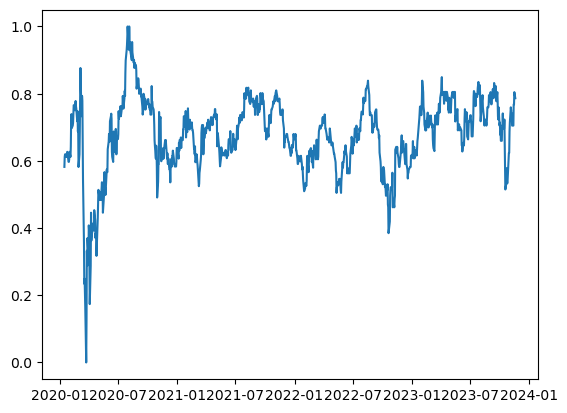

In [78]:
# plt.plot(close_frame.index, close_frame['difference'])
plt.plot(close_frame.index, close_frame['Close'])

In [79]:
close_frame_np = close_frame.to_numpy()
close_frame_np[:5]

array([[0.58206917, 0.57458648, 0.57458648, 0.56710357, 0.55962045,
        0.55213775, 0.52968946, 0.50724053, 0.4997574 , 0.4997574 ,
        0.49227407, 0.49227407, 0.49227407, 0.4773089 , 0.4773089 ,
        0.4773089 , 0.46234308, 0.44737705, 0.44737705, 0.45485996,
        0.44737705, 0.44737705, 0.44737705, 0.50724053, 0.52220613,
        0.52220613, 0.53717194, 0.52968946, 0.52220613, 0.50724053,
        0.514723  , 0.49227407, 0.4997574 , 0.4773089 , 0.50724053,
        0.4997574 , 0.45485996, 0.46982578, 0.44737705, 0.44737705],
       [0.6120008 , 0.58206917, 0.57458648, 0.57458648, 0.56710357,
        0.55962045, 0.55213775, 0.52968946, 0.50724053, 0.4997574 ,
        0.4997574 , 0.49227407, 0.49227407, 0.49227407, 0.4773089 ,
        0.4773089 , 0.4773089 , 0.46234308, 0.44737705, 0.44737705,
        0.45485996, 0.44737705, 0.44737705, 0.44737705, 0.50724053,
        0.52220613, 0.52220613, 0.53717194, 0.52968946, 0.52220613,
        0.50724053, 0.514723  , 0.49227407, 0.4

In [80]:
X = close_frame_np[:, 1:]
y = close_frame_np[:, 0]
X.shape, y.shape

((967, 39), (967,))

In [81]:
# train_split = int(np.ceil(X.shape[0]*0.7))
# test_split = int(np.ceil((len(X)-train_split)*0.5+train_split))
test_split = int(np.ceil(len(X)*0.7))
train_split = int(np.ceil(test_split*0.8))
train_split, test_split

(542, 677)

In [82]:
# X_train = torch.tensor(X[:1000]).float()
X_train = torch.tensor(X[:train_split]).float()
y_train = torch.tensor(y[:train_split]).float()

X_test = torch.tensor(X[test_split:]).float()
y_test = torch.tensor(y[test_split:]).float()

X_val = torch.tensor(X[train_split:test_split]).float()
y_val = torch.tensor(y[train_split:test_split]).float()
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([542, 39]),
 torch.Size([542]),
 torch.Size([135, 39]),
 torch.Size([135]),
 torch.Size([290, 39]),
 torch.Size([290]))

In [83]:
# plt.plot(close_frame.index[:test_split], close_frame['difference'][:test_split])

In [84]:
# plt.plot(close_frame.index[test_split:], close_frame['difference'][test_split:])

In [85]:
batch_size = 32
training_loader = load_window_frame_dataset(X_train, y_train, batch_size)
val_loader = load_window_frame_dataset(X_val, y_val, batch_size)
testing_loader = load_window_frame_dataset(X_test, y_test, batch_size)

Helpers

In [345]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize = (20,10))
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title, fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

def plot_prediction(model, title, mode="test"):
    """

    :param model:
    :param mode:
    :return:
    """
    if mode == "train":
        data_x = X_train
        data_y = y_train
    elif mode == "validation":
        data_x = X_val
        data_y = y_val
    elif mode == "test":
        data_x = X_test
        data_y = y_test
    else:
        print("invalid mode")
        return
    with torch.no_grad():
        predicted = model(data_x.to(device)).to('cpu').numpy()
    plt.figure(figsize = (20,10))
    plt.plot(data_y.to('cpu').numpy(), label='Actual Close')
    plt.plot(predicted, label='Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend(fontsize=16)
    plt.title(title, fontsize=16)
    plt.show()

def train_one_epoch(model, epoch, criterion, optimizer, loader):
        model.train(True)
        # print(f'Epoch: {epoch + 1}')
        running_loss = 0.0

        for batch_index, batch in enumerate(loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # print(f"Epoch {epoch}, Loss: {running_loss:.3f}\n")
        return np.sqrt(running_loss)

def validate_one_epoch(model, criterion, loader):
    """

    :param mlp:
    :param criterion:
    :return: the RMSE of the testing samples
    """
    model.train(False)
    running_loss = 0.0
    # correct = 0
    for batch_index, batch in enumerate(loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

    return np.sqrt(running_loss)

def train(model, _criterion, _optimizer, _train_loader, _test_loader):
    training_loss, val_loss = [], []
    for _epoch in range(num_epochs):
        training_loss.append(train_one_epoch(model, _epoch, _criterion, _optimizer, _train_loader))
        val_loss.append(validate_one_epoch(model, _criterion, _test_loader))
    return training_loss, val_loss

In [87]:
learning_rate = 0.001
num_epochs = 100

## seMLP

In [88]:
from seMLP import seMLP
torch.set_default_device(device)

In [89]:
semlp = seMLP(training_loader, val_loader, window-1, population=100, ga_path="./GA/latest.pkl")

In [90]:
# semlp.run(25)

In [468]:
import re
file_path = "./GA.txt"
# Read the data from the text file
with open(file_path, 'r') as f:
    lines = f.readlines()
history = []
reached = False
for line in lines:

    if len(history) >= 25:
        break

    if "2023-11-16_23-48-13" in line:
        reached = True

    if not reached:
        continue

    if "==" in line or "Genetic" in line:
        continue

    parts = line.split("), ")
    parts = parts[:10]

    layers, rmses, scores = [], [], []
    for chromosome_string in parts:
        layers_match = re.search(r"layers=\[(.*?)\]", chromosome_string)
        rmse_match = re.search(r"RMSE=(.*?),", chromosome_string)
        score_match = re.search(r"score=(.*?)$", chromosome_string)

        layers.append(layers_match.group(1).split(", "))
        rmses.append(rmse_match.group(1))
        scores.append(score_match.group(1))
    history.append( [layers, rmses, scores])


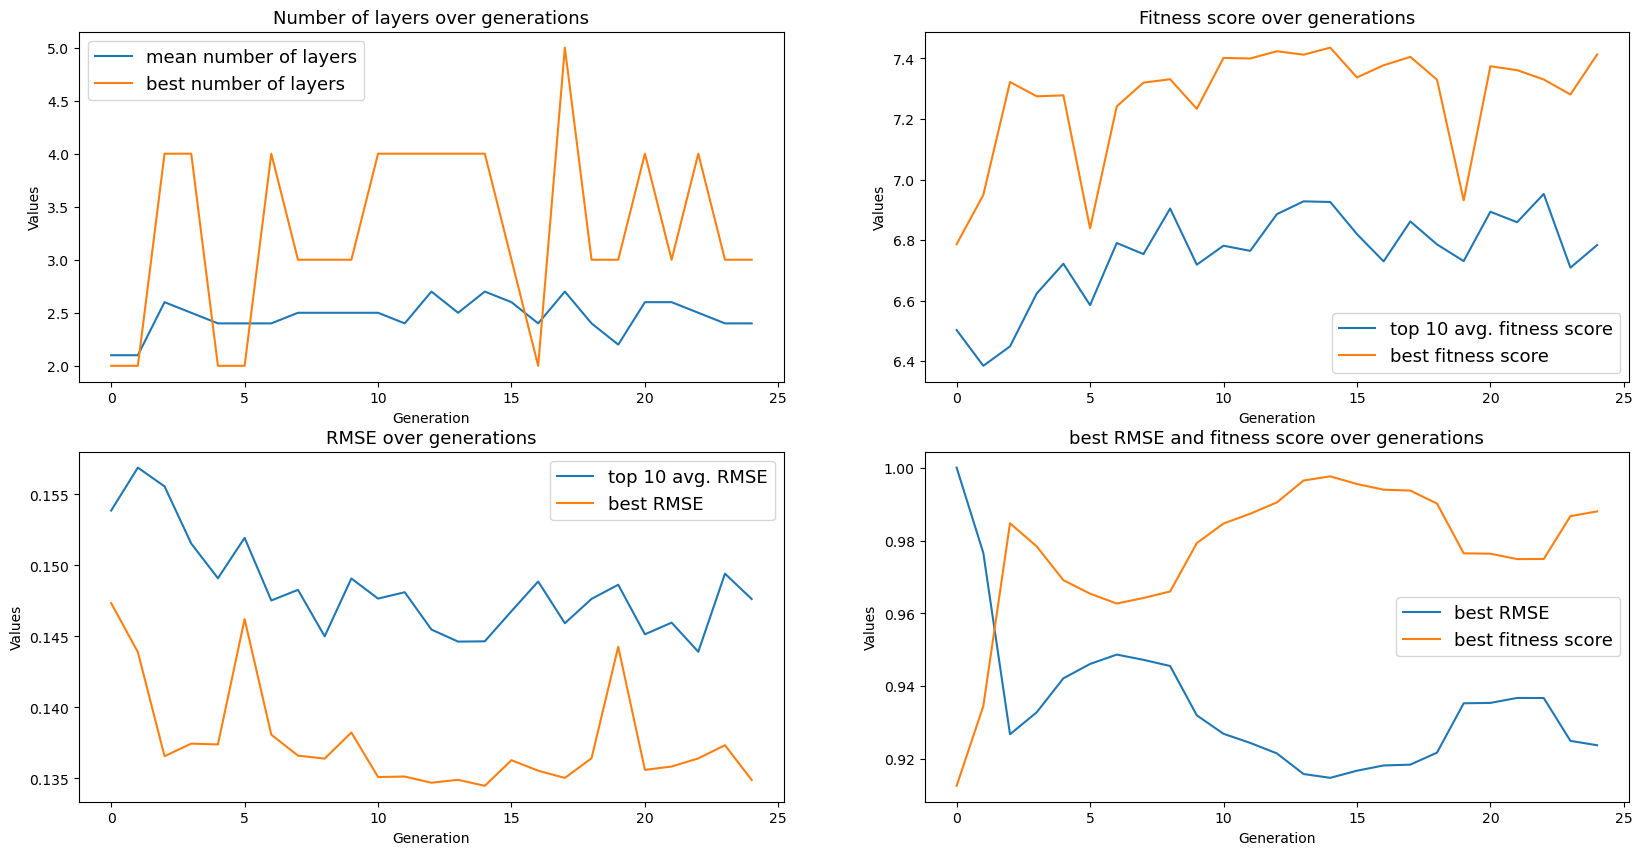

In [534]:
best_rmse_over_epoch, best_score_over_epoch, best_layer, top10_layers_mean, top10_rmse_mean, top10_score_mean, best_num_layers = [], [], [], [], [], [], []
for i in range(len(history)):
    best_rmse_over_epoch.append(float(history[i][1][0]))
    best_score_over_epoch.append(float(history[i][2][0]))
    best_layer.append(history[i][0][0])
    best_num_layers.append(len(history[i][0][0]))
    mean_layer, mean_rmse, mean_score = 0, 0, 0
    for k, j in enumerate(history[i][0]):
        mean_layer += len(j)
        mean_rmse += float(history[i][1][k])
        mean_score += float(history[i][2][k])
    mean_layer /= len(history[i][0])
    mean_rmse /= len(history[i][0])
    mean_score /= len(history[i][0])
    top10_layers_mean.append(mean_layer)
    top10_rmse_mean.append(mean_rmse)
    top10_score_mean.append(mean_score)

plt.figure(figsize = (20,10))
plt.subplot(2, 2, 1)

plt.plot(top10_layers_mean, label="mean number of layers")
plt.plot(best_num_layers, label="best number of layers")
plt.xlabel('Generation')
plt.ylabel('Values')
plt.title("Number of layers over generations", fontsize=13)
plt.legend(fontsize=13)

plt.subplot(2, 2, 2)

plt.plot(top10_score_mean, label="top 10 avg. fitness score")
plt.plot(best_score_over_epoch, label="best fitness score")
# plt.plot(top10_rmse_mean, label="top 10 avg. RMSE")
plt.xlabel('Generation')
plt.ylabel('Values')
plt.title("Fitness score over generations", fontsize=13)
plt.legend(fontsize=13)

plt.subplot(2, 2, 3)

plt.plot(top10_rmse_mean, label="top 10 avg. RMSE")
plt.plot(best_rmse_over_epoch, label="best RMSE")
# plt.plot(top10_rmse_mean, label="top 10 avg. RMSE")
plt.xlabel('Generation')
plt.ylabel('Values')
plt.title("RMSE over generations", fontsize=13)
plt.legend(fontsize=13)

plt.subplot(2, 2, 4)

best_score_over_epoch = np.array(best_score_over_epoch)
best_rmse_over_epoch = np.array(best_rmse_over_epoch)
best_rmse_over_epoch = best_rmse_over_epoch/max(best_rmse_over_epoch)
best_score_over_epoch= best_score_over_epoch/max(best_score_over_epoch)

w = 4
arr1, arr2 = np.zeros(len(best_rmse_over_epoch)), np.zeros(len(best_score_over_epoch))
for i in range(w-1, len(arr1)):
    arr1[i] = np.mean(best_rmse_over_epoch[i-w+1:i+1])
    arr2[i] = np.mean(best_score_over_epoch[i-w+1:i+1])
arr1[:w] = best_rmse_over_epoch[:w]
arr2[:w] = best_score_over_epoch[:w]

plt.plot(arr1, label="best RMSE")
plt.plot(arr2, label="best fitness score")
plt.xlabel('Generation')
plt.ylabel('Values')
plt.title("best RMSE and fitness score over generations", fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [91]:
XX_train = torch.tensor(X[:test_split]).float()
yy_train = torch.tensor(y[:test_split]).float()

training_loader = load_window_frame_dataset(XX_train, yy_train, batch_size)
XX_train.shape, yy_train.shape

(torch.Size([677, 39]), torch.Size([677]))

In [300]:
from MLP import MLP
# mlp = MLP(window-1, 1, [6, 63])#semlp.GA.winner().get_layers()
mlp = MLP(window-1, 1, semlp.GA.winner().get_layers())#semlp.GA.winner().get_layers()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

mlp_training_loss, mlp_validation_loss = train(mlp, criterion, optimizer, training_loader, testing_loader)

C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


In [301]:
with torch.no_grad():
    semlp_pred = mlp(X_test.to(device)).to('cpu').numpy()

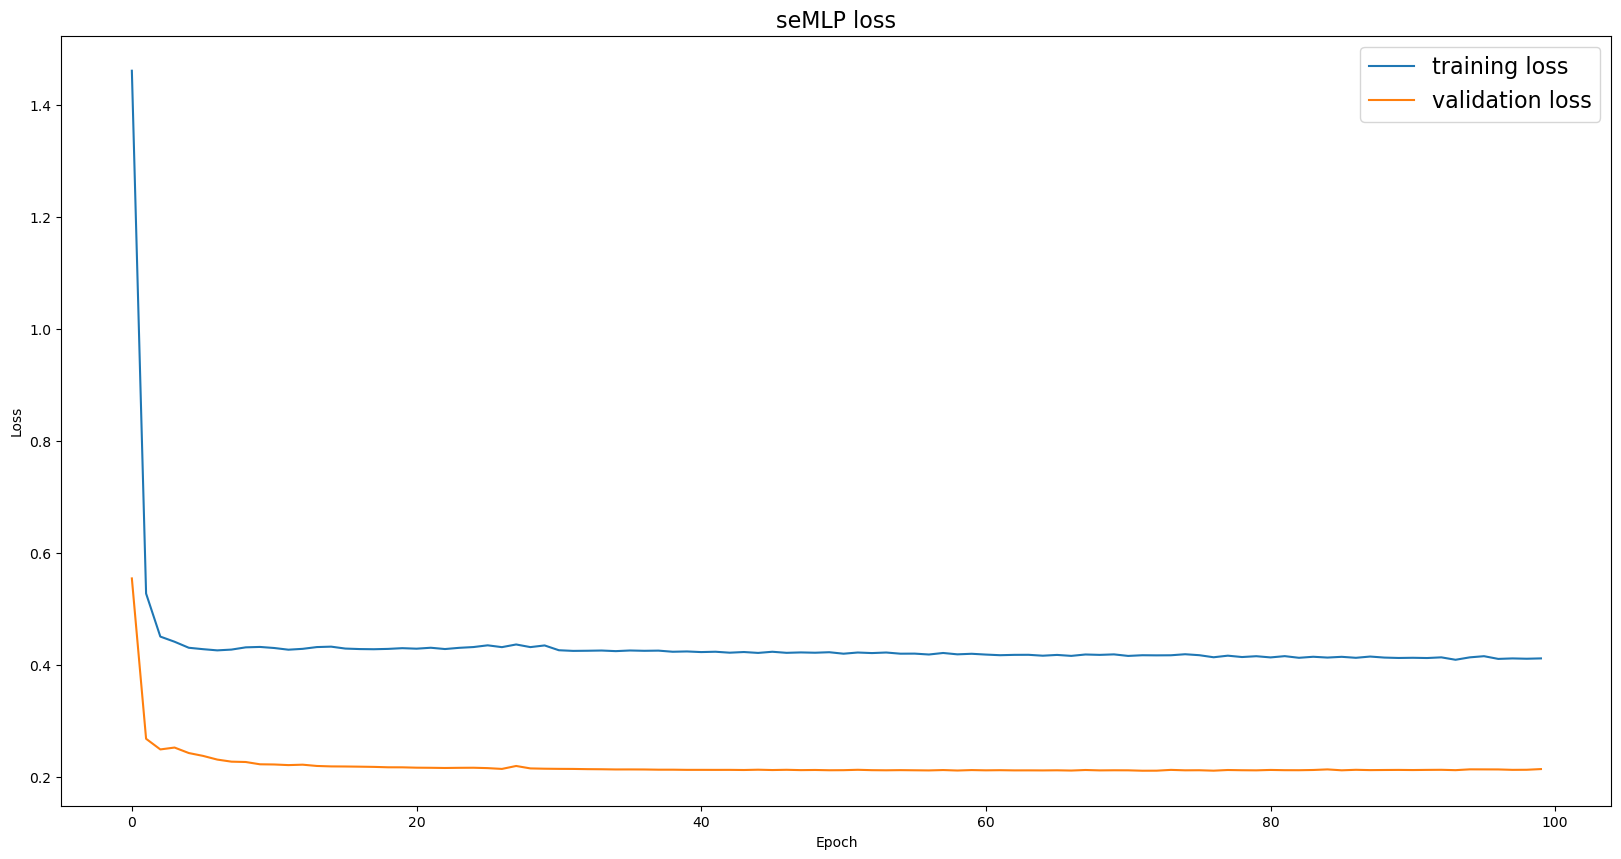

In [344]:
plot_loss(mlp_training_loss, mlp_validation_loss, "seMLP loss")

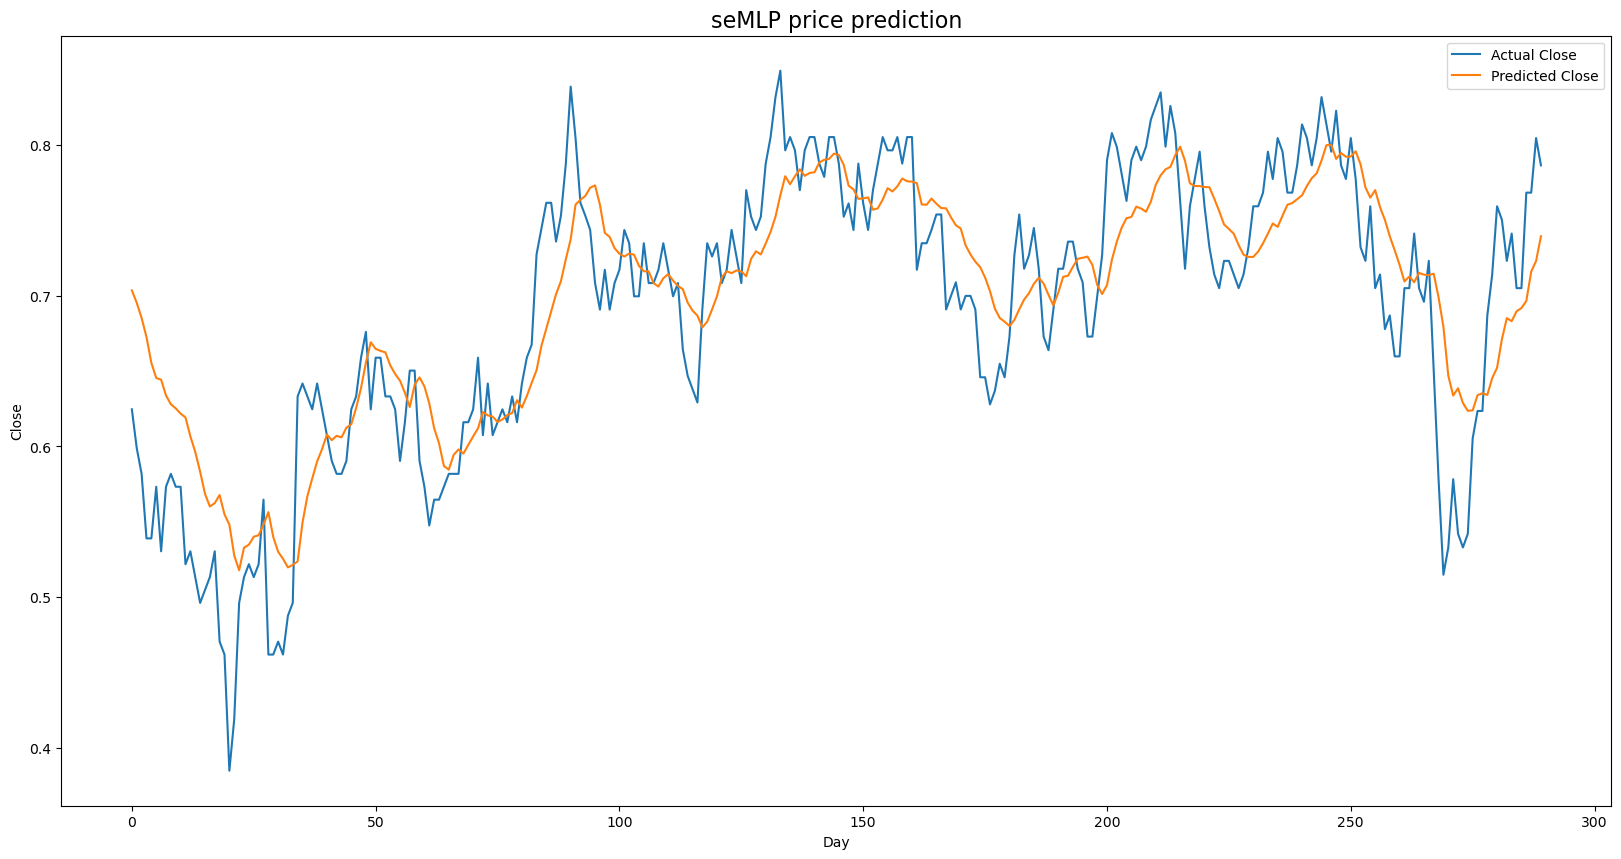

In [337]:
plot_prediction(mlp, "seMLP price prediction", mode="test")

## Evaluation

### Moving Average

In [304]:
def moving_avg(data):
    if isinstance(data, torch.Tensor):
        numpy_data = data.to('cpu').numpy()
    else:
        numpy_data = data
    col = np.copy(numpy_data)
    if col.ndim == 2:
        col = col[:, 0]
    shifted = np.zeros_like(col)
    shifted[1:] = col[:-1]
    shifted[0] = np.nan
    return shifted

In [305]:
moving_pred = moving_avg(X_test)

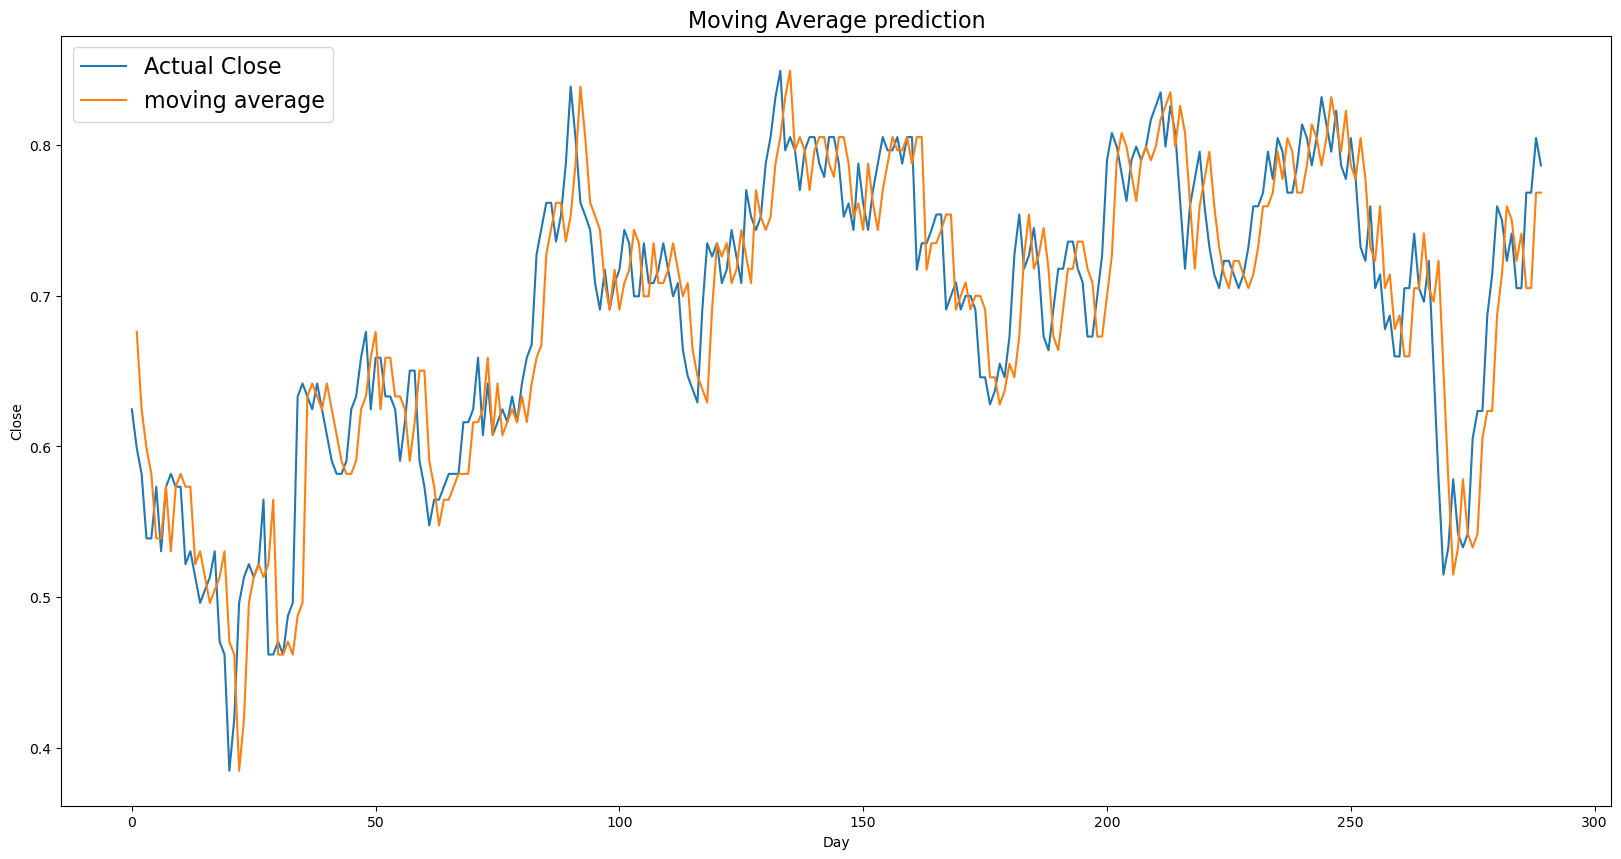

In [346]:
plt.figure(figsize = (20,10))
plt.plot(y_test.to('cpu').numpy(), label='Actual Close')
plt.plot(moving_pred, label='moving average')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend(fontsize=16)
plt.title("Moving Average prediction", fontsize=16)
plt.show()

# plot_prediction(mlp, "Moving Average prediction")

### LSTM

In [307]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x=x.unsqueeze(2)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        # h0 = h0.unsqueeze(2)
        # c0 = c0.unsqueeze(2)
        # print(h0.size())
        # print(x.size())
        x = x.unsqueeze(1)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [308]:
lstm = LSTM(window-1, 5, 1)
# lstm = LSTM(window-1, 5, 2)
lstm.to(device)
lstm

LSTM(
  (lstm): LSTM(39, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [309]:
learning_rate = 0.001
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
lstm_training_loss, lstm_val_loss = train(lstm, criterion, optimizer, training_loader, testing_loader)

In [354]:
with torch.no_grad():
    lstm_pred = lstm(X_test.to(device)).to('cpu').numpy()

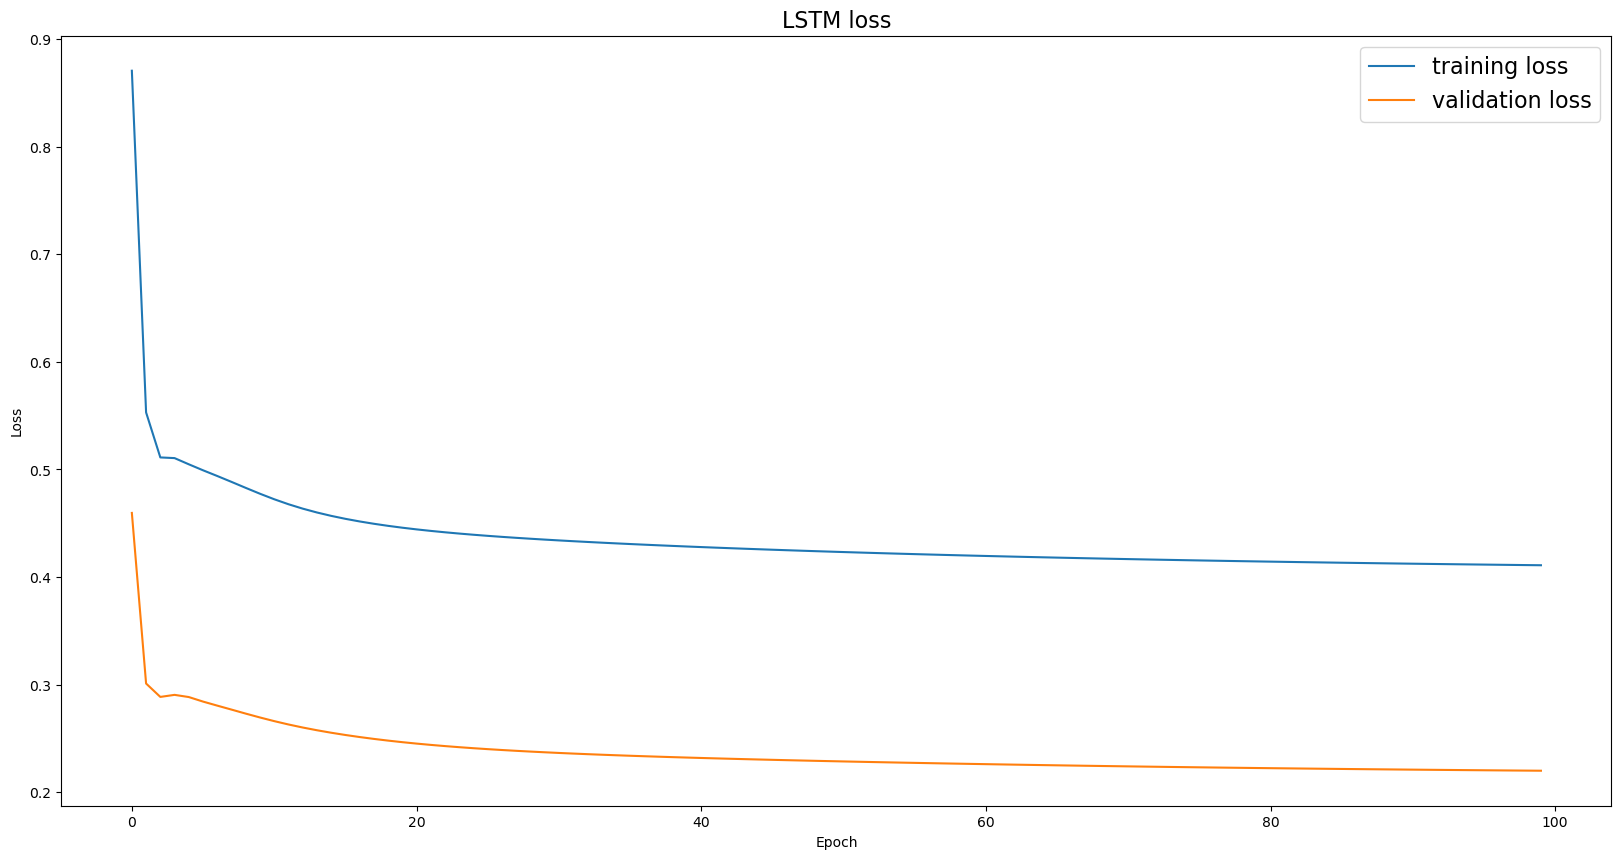

In [355]:
plot_loss(lstm_training_loss, lstm_val_loss, "LSTM loss")

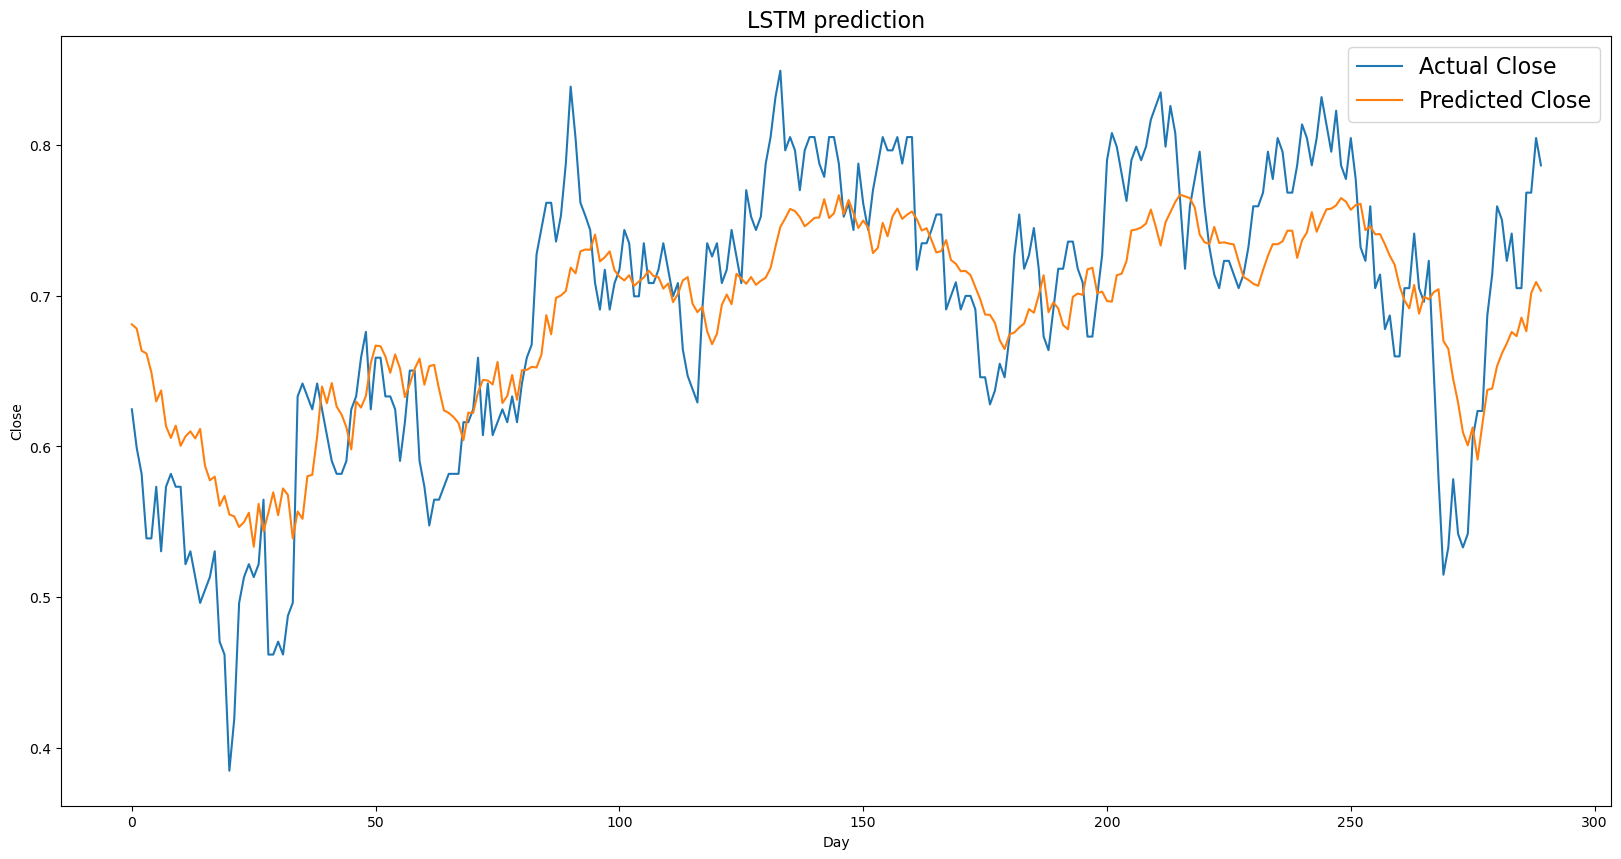

In [356]:
# plt.plot(moving_pred, label='moving average')
# plt.plot(semlp_pred, label='seMLP')
plot_prediction(lstm, "LSTM prediction", "test")

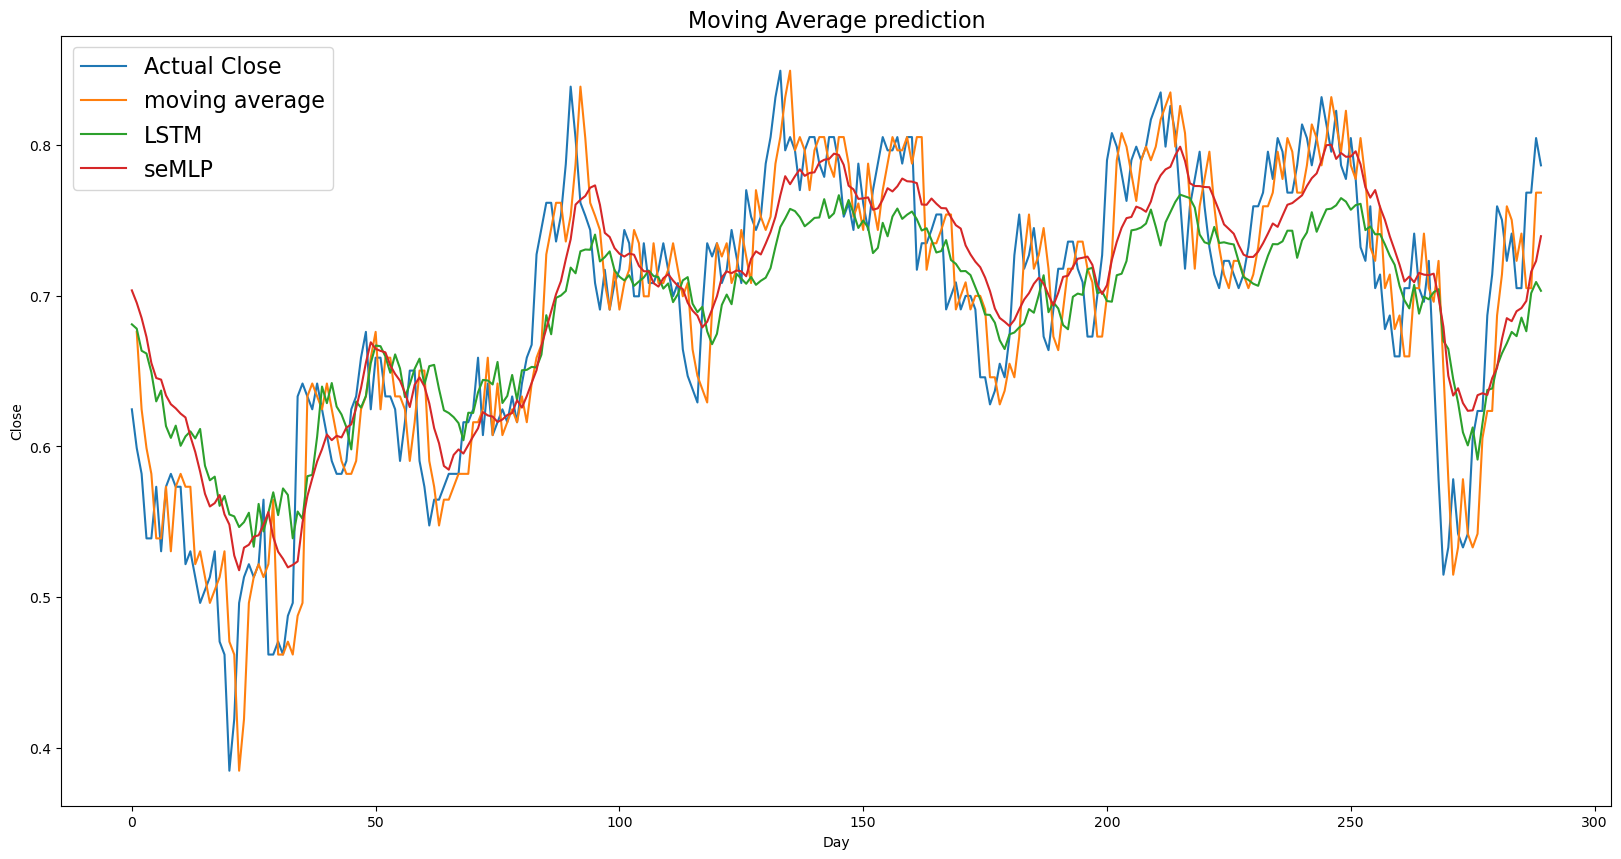

In [357]:
plt.figure(figsize = (20,10))
plt.plot(y_test.to('cpu').numpy(), label='Actual Close')
plt.plot(moving_pred, label='moving average')
plt.plot(lstm_pred, label='LSTM')
plt.plot(semlp_pred, label='seMLP')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend(fontsize=16)
plt.title("Moving Average prediction", fontsize=16)
plt.show()

## Analysis

In [358]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import KFold


def k_fold_validation(selected_model, *param):
    k = 5
    splits=KFold(n_splits=k)
    res = []
    models = []
    test_size = round(len(X)/k)
    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(X)))):
        k_fold_train_loader = load_window_frame_dataset(torch.tensor(X[train_idx]).float(), torch.tensor(y[train_idx]).float(), batch_size=batch_size)
        k_fold_test_loader = load_window_frame_dataset(torch.tensor(X[val_idx]).float(), torch.tensor(y[val_idx]).float(), batch_size=batch_size)

        model = selected_model(*param)
        model.to(device)

        res.append(train(model, criterion, optimizer, k_fold_train_loader, k_fold_test_loader))
        models.append(model)
    return {"loss": res, "models": models}


In [359]:
# semlp_k_fold = k_fold_validation(LSTM, window-1, 5, 1)
# semlp_k_fold = k_fold_validation(MLP, window-1, 1, semlp.GA.winner().get_layers())

In [360]:
def tensor_to_1d(data):
    if isinstance(data, torch.Tensor):
        numpy_data = data.to('cpu').numpy()
    else:
        numpy_data = data
    if numpy_data.ndim == 2:
        numpy_data = np.copy(numpy_data[:, 0])
    return numpy_data

def sma(data, _window):
    col = tensor_to_1d(data)
    ma = np.zeros_like(col)
    for i in range(_window-1, len(data)):
        ma[i] = np.mean(col[i-_window+1:i+1])
    ma[:_window] = np.nan
    return ma

def sma_trading_signal(data, slow_window=100, fast_window=20):
    _slow = sma(data, slow_window)
    _fast = sma(data, fast_window)
    # _signal = _fast > _slow
    _signal = np.where(_fast > _slow, 1.0, 0.0)
    _signal[:slow_window-1] = np.nan
    pos = np.diff(_signal)

    wave = np.zeros_like(_slow)
    prev = 0
    for i in range(1, len(wave)):
        if pos[i-1] != 0 and pos[i-1] != np.nan:
            prev = pos[i-1]
        wave[i] = prev
    pos = np.concatenate((np.array([0]),pos))
    return {"slow": _slow, "fast": _fast, "pos": pos, "wave": wave}

def cal_rsi(data, window_size):
    ret = np.diff(data)
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = window_size - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = window_size - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.to_numpy()
    # rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    # rsi_df = rsi_df.dropna()
    return rsi

def rsi_trading_signal(data, window_size, oversold=30, overbought=70):
    col = tensor_to_1d(data)
    rsi = cal_rsi(col, window_size)
    rsi = np.concatenate((np.array([np.nan]),rsi))
    # rsi[:window_size+1] = np.nan
    pos, wave = np.zeros_like(col), np.zeros_like(col)
    prev = 0
    for i in range(1, len(rsi)):
        if rsi[i - 1] > oversold > rsi[i]:
            if prev == 1:
                continue
            pos[i] = 1
            prev = 1
        elif rsi[i - 1] < overbought < rsi[i]:
            if prev == -1:
                continue
            pos[i] = -1
            prev = -1
    prev = 0
    for i in range(1, len(wave)):
        if pos[i-1] != 0 and pos[i-1] != np.nan:
            prev = pos[i-1]
        wave[i] = prev
    return {"rsi": rsi, "pos": pos, "wave": wave}

def plot_sma_trading_signal(_trade_data, _slow, _fast, _position, title):
    plt.figure(figsize = (20,10))
    d = tensor_to_1d(_trade_data)
    plt.plot(d)
    plt.plot(_slow)
    plt.plot(_fast)
    plt.plot(np.arange(0,len(_fast))[_position==1], _fast[_position==1], '^', markersize = 15, color = 'g', label = 'buy')
    plt.plot(np.arange(0,len(_slow))[_position==-1], _slow[_position==-1], 'v', markersize = 15, color = 'r', label = 'sell')
    plt.legend()
    plt.title(title, fontsize=16)
    plt.show()

def plot_rsi_trading_signal(_trade_data, _position, rsi, oversold, overbought, title):
    plt.figure(figsize = (20,10))
    d = tensor_to_1d(_trade_data)
    plt.plot(d)
    plt.plot(rsi/100)
    plt.plot(np.arange(0,len(d))[_position==1], d[_position==1], '^', markersize = 15, color = 'g', label = 'buy')
    plt.plot(np.arange(0,len(d))[_position==-1], d[_position==-1], 'v', markersize = 15, color = 'r', label = 'sell')
    plt.axhline(y = oversold/100, color = 'r', linestyle = 'dashed')
    plt.axhline(y = overbought/100, color = 'r', linestyle = 'dashed')
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()


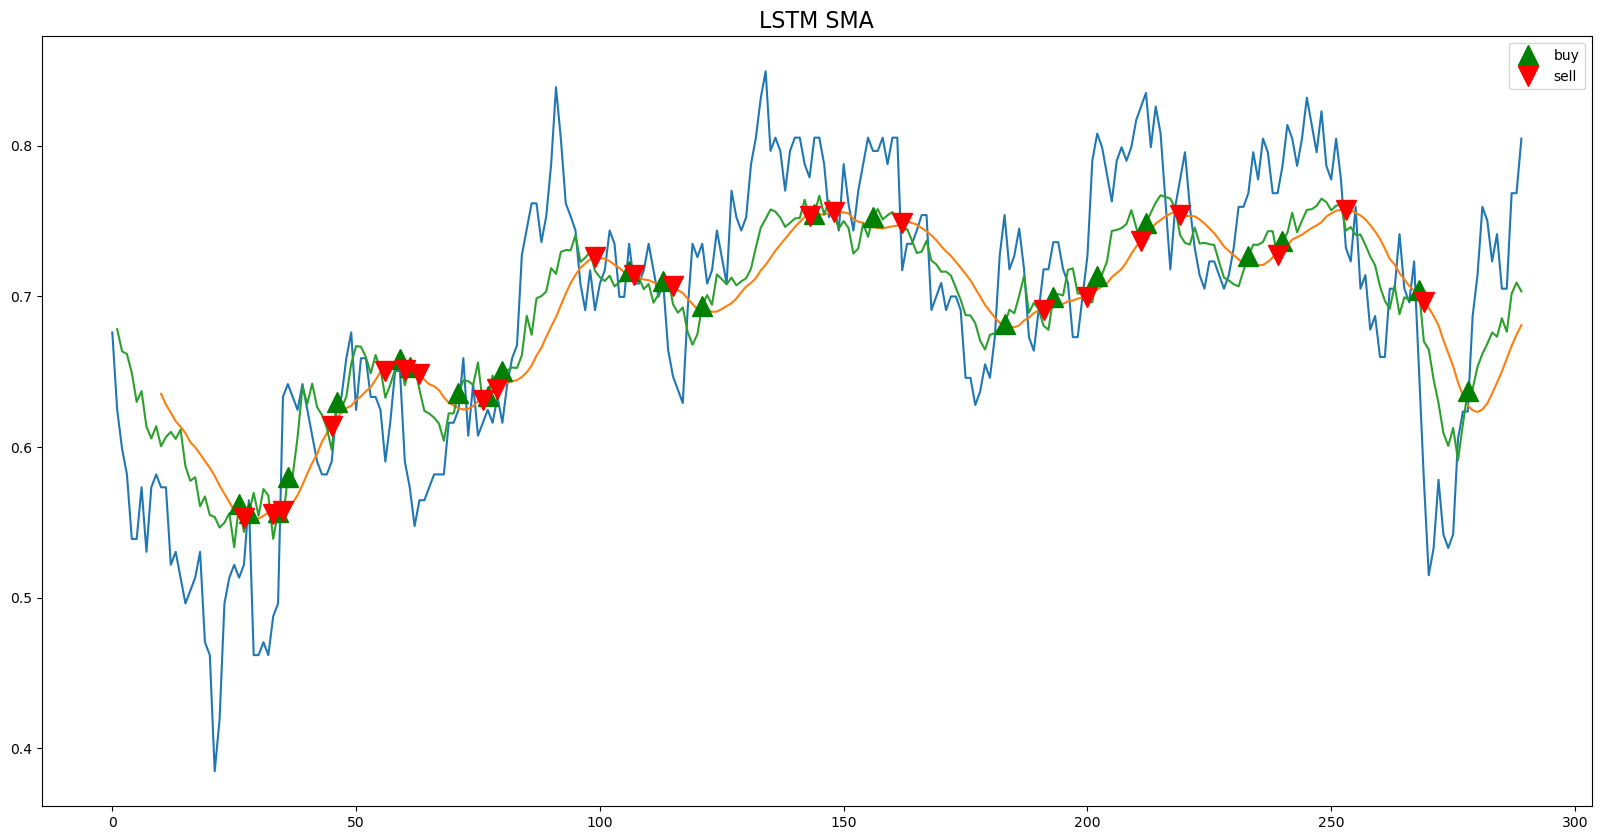

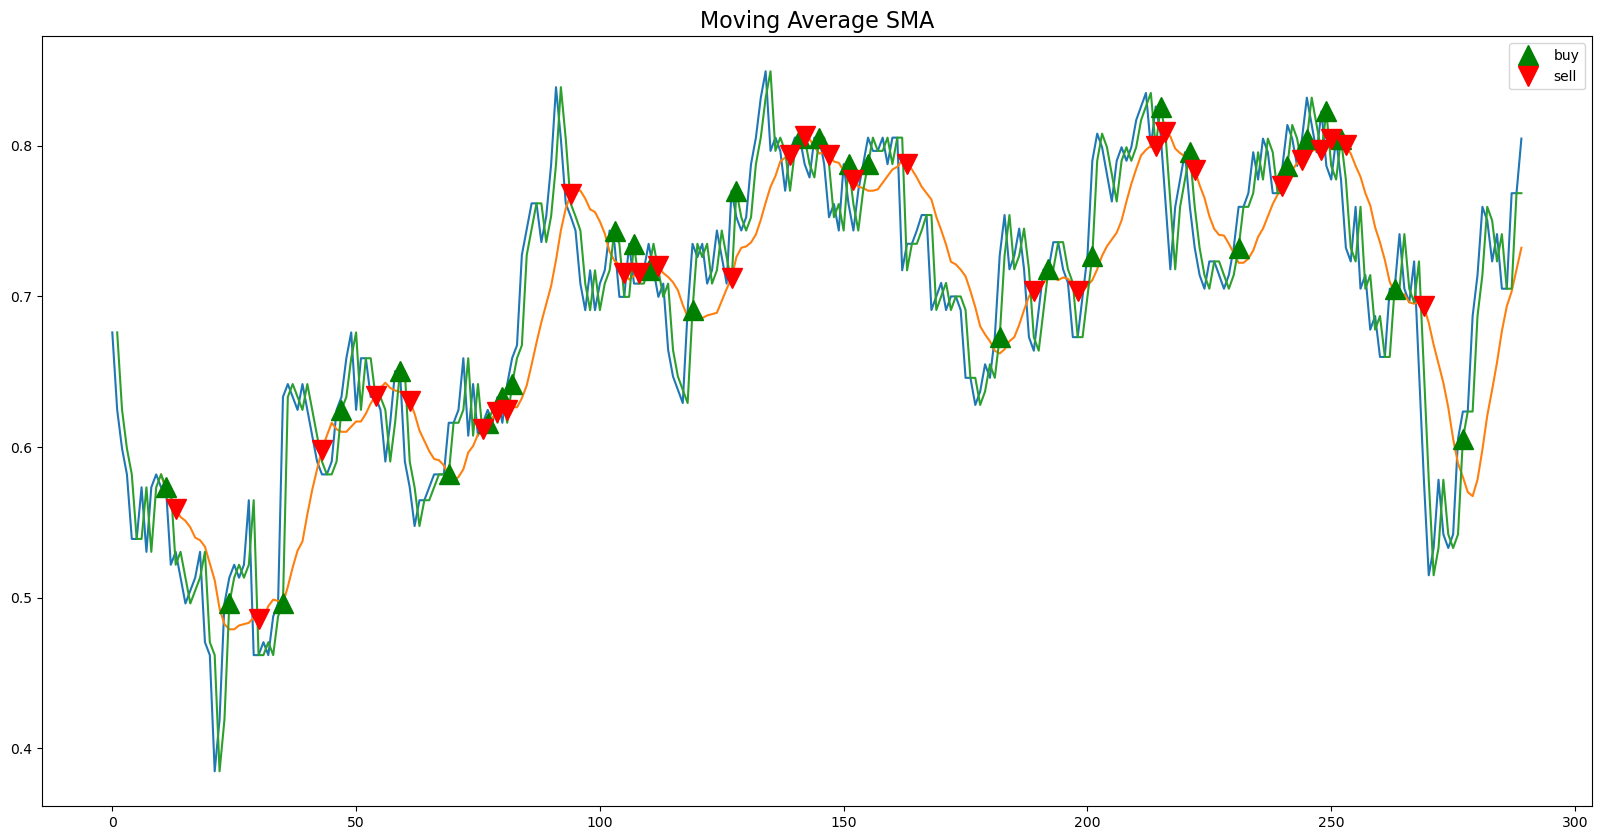

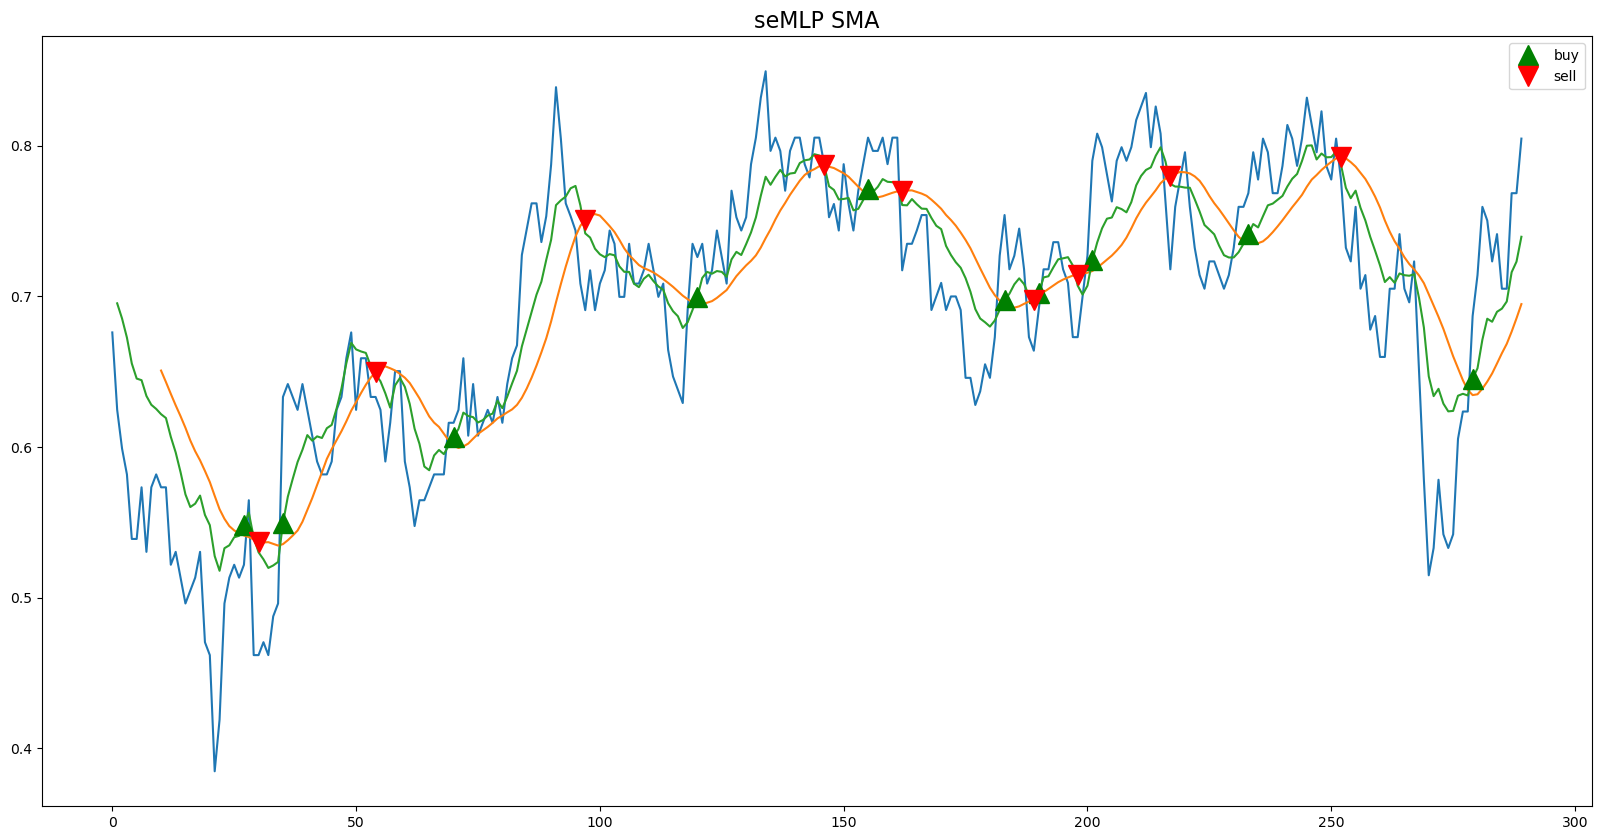

In [402]:
trade_data = X_test
sma_res = sma_trading_signal(lstm_pred, fast_window=1, slow_window=10)
plot_sma_trading_signal(trade_data[:, 0], sma_res['slow'], sma_res['fast'], sma_res['pos'], "LSTM SMA")
sma_res = sma_trading_signal(moving_pred, fast_window=1, slow_window=10)
plot_sma_trading_signal(trade_data[:, 0], sma_res['slow'], sma_res['fast'], sma_res['pos'], "Moving Average SMA")
sma_res = sma_trading_signal(semlp_pred, fast_window=1, slow_window=10)
plot_sma_trading_signal(trade_data[:, 0], sma_res['slow'], sma_res['fast'], sma_res['pos'], "seMLP SMA")

C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\mpld3\mplexporter\exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


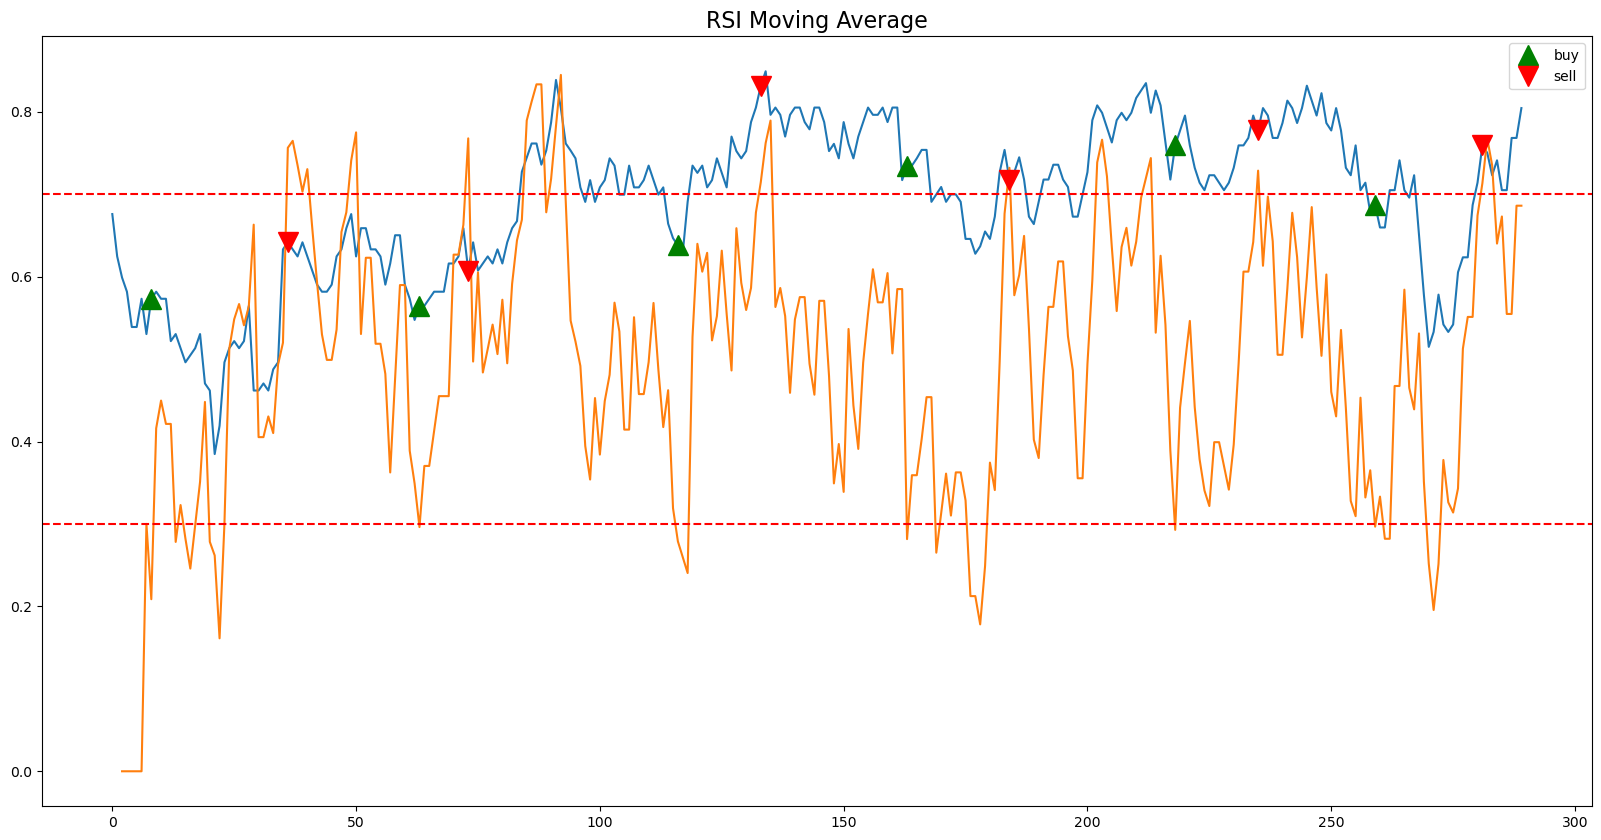

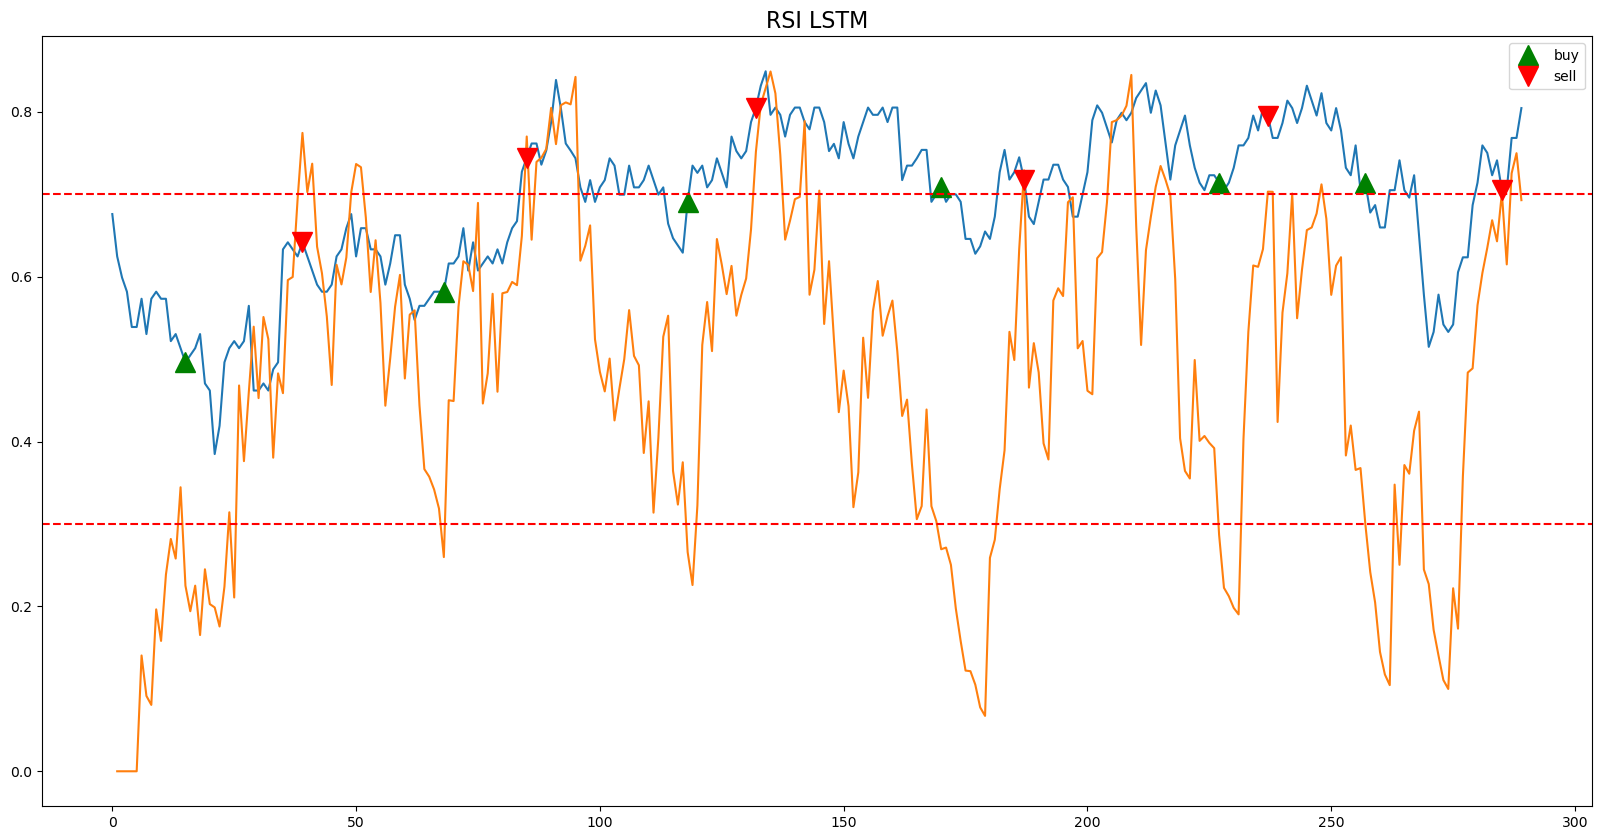

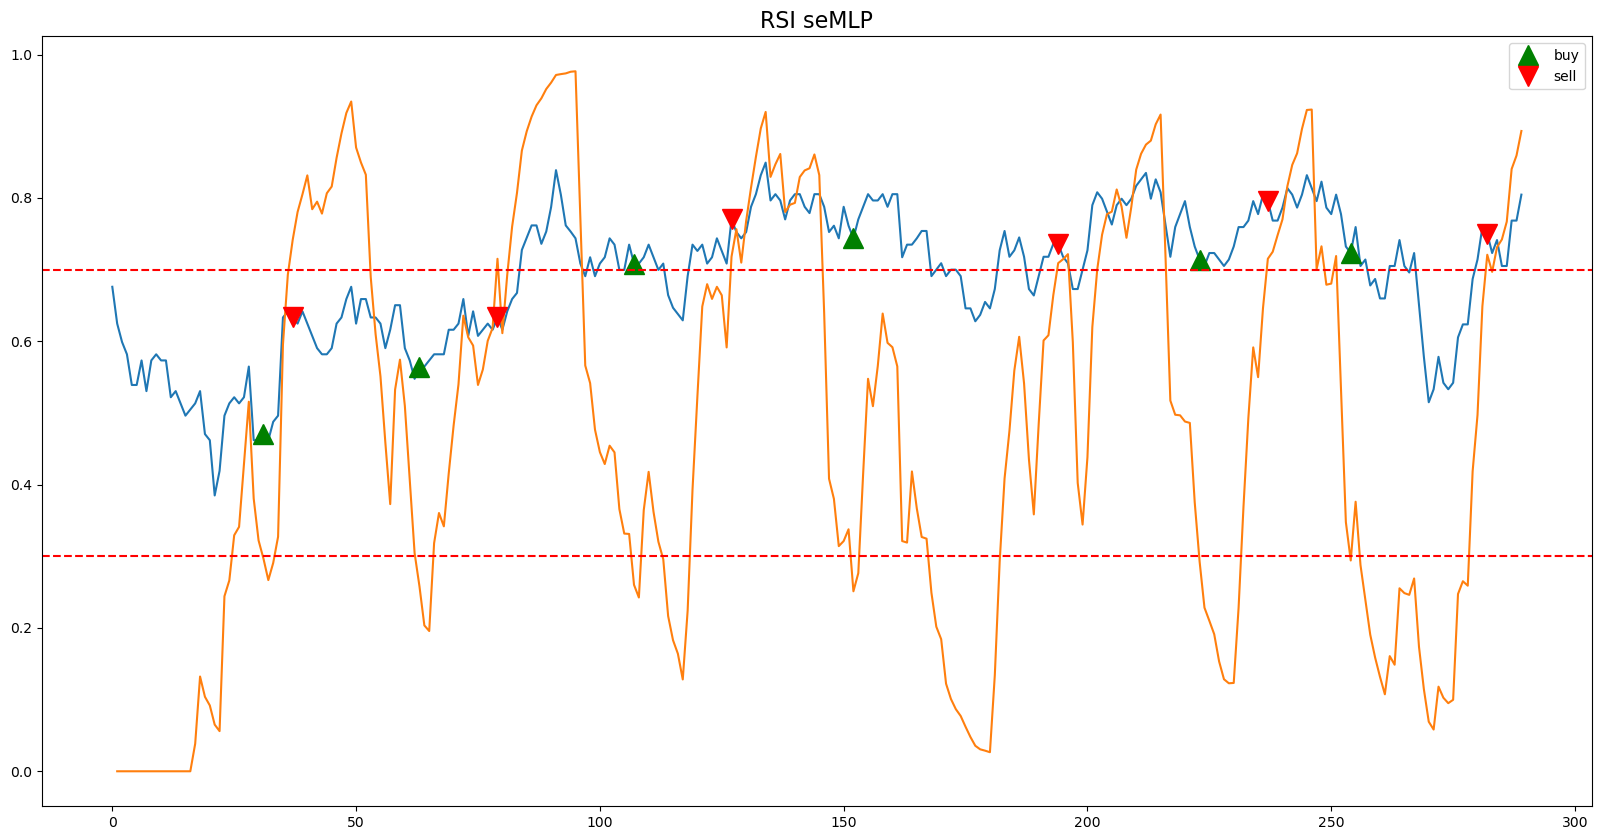

In [362]:
trade_data = X_test
over_sold, over_bought = 30, 70
rsi_res = rsi_trading_signal(moving_pred, 7, over_sold, over_bought)
plot_rsi_trading_signal(trade_data[:,0], rsi_res['pos'], rsi_res['rsi'], over_sold, over_bought, "RSI Moving Average")
rsi_res = rsi_trading_signal(lstm_pred, 7, over_sold, over_bought)
plot_rsi_trading_signal(trade_data[:,0], rsi_res['pos'], rsi_res['rsi'], over_sold, over_bought, "RSI LSTM")
rsi_res = rsi_trading_signal(semlp_pred, 7, over_sold, over_bought)
plot_rsi_trading_signal(trade_data[:,0], rsi_res['pos'], rsi_res['rsi'], over_sold, over_bought, "RSI seMLP")

In [363]:
def compute_income(data, prediction, _charge_rate, trade_func, *param):
    res = trade_func(prediction, *param)
    price_rate = tensor_to_1d(data)
    price_rate = price_rate.reshape(-1, 1)
    price_rate = min_max_scaler.inverse_transform(price_rate) # Set it back to original scale
    price_rate = np.reshape(price_rate, -1)
    net = 1
    net_changes = np.zeros_like(price_rate)
    prev_price_rate = 0
    for i in range(len(res['wave'])):
        if res['pos'][i] == 1 or res['pos'][i] == -1: # buy or sell
            net -= net * _charge_rate
        if res['wave'][i] == 1:
            net += net * (price_rate[i] - prev_price_rate) # today price rate - previous price rate
        net_changes[i] = net
        prev_price_rate = price_rate[i]
    return net_changes

In [444]:
charge_rate = 0.005
params = (10, 1) # slow, fast
# params = (10, 5)
trading_set = X_test
trading_strategy = sma_trading_signal

semlp_income = compute_income(trading_set, semlp_pred, charge_rate, trading_strategy, *params)
moving_income = compute_income(trading_set, moving_pred, charge_rate, trading_strategy, *params)
lstm_income = compute_income(trading_set, lstm_pred, charge_rate, trading_strategy, *params)

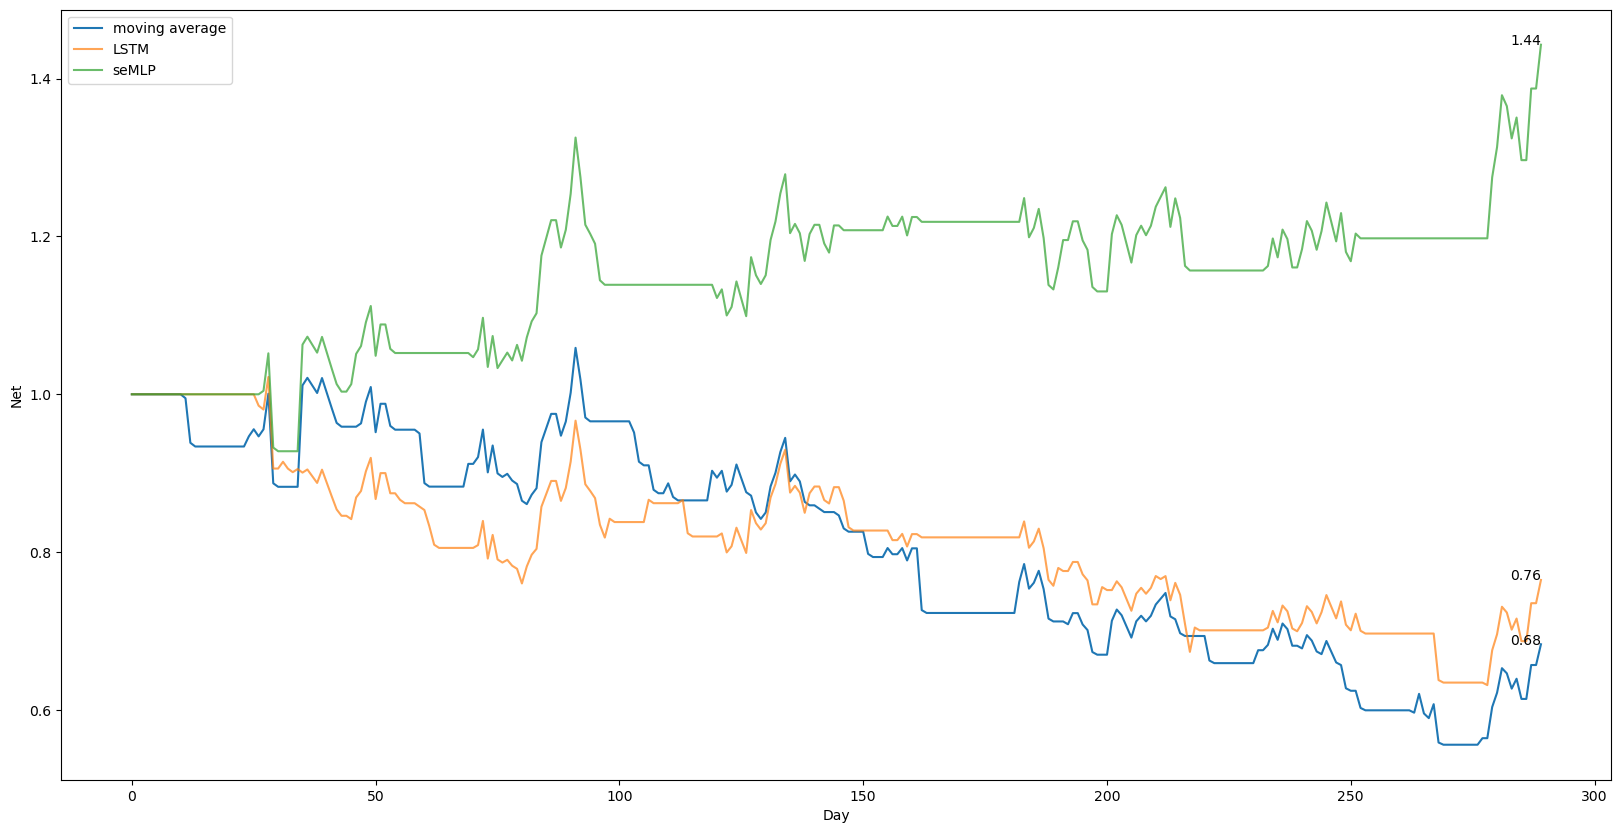

In [445]:
plt.figure(figsize = (20,10))
plt.plot(moving_income, label="moving average")
plt.plot(lstm_income, label="LSTM", alpha=0.7)
plt.plot(semlp_income, label="seMLP", alpha=0.7)
for var in (semlp_income, moving_income, lstm_income):
    plt.annotate(f'{var[-1]:.2f}', (len(var)-1, var[-1]), ha='right')
plt.xlabel('Day')
plt.ylabel('Net')
plt.legend()
plt.show()

In [408]:
charge_rate = 0.005
params = (14,)
trading_set = X_test
trading_strategy = rsi_trading_signal

semlp_income = compute_income(trading_set, semlp_pred, charge_rate, trading_strategy, *params)
moving_income = compute_income(trading_set, moving_pred, charge_rate, trading_strategy, *params)
lstm_income = compute_income(trading_set, lstm_pred, charge_rate, trading_strategy, *params)

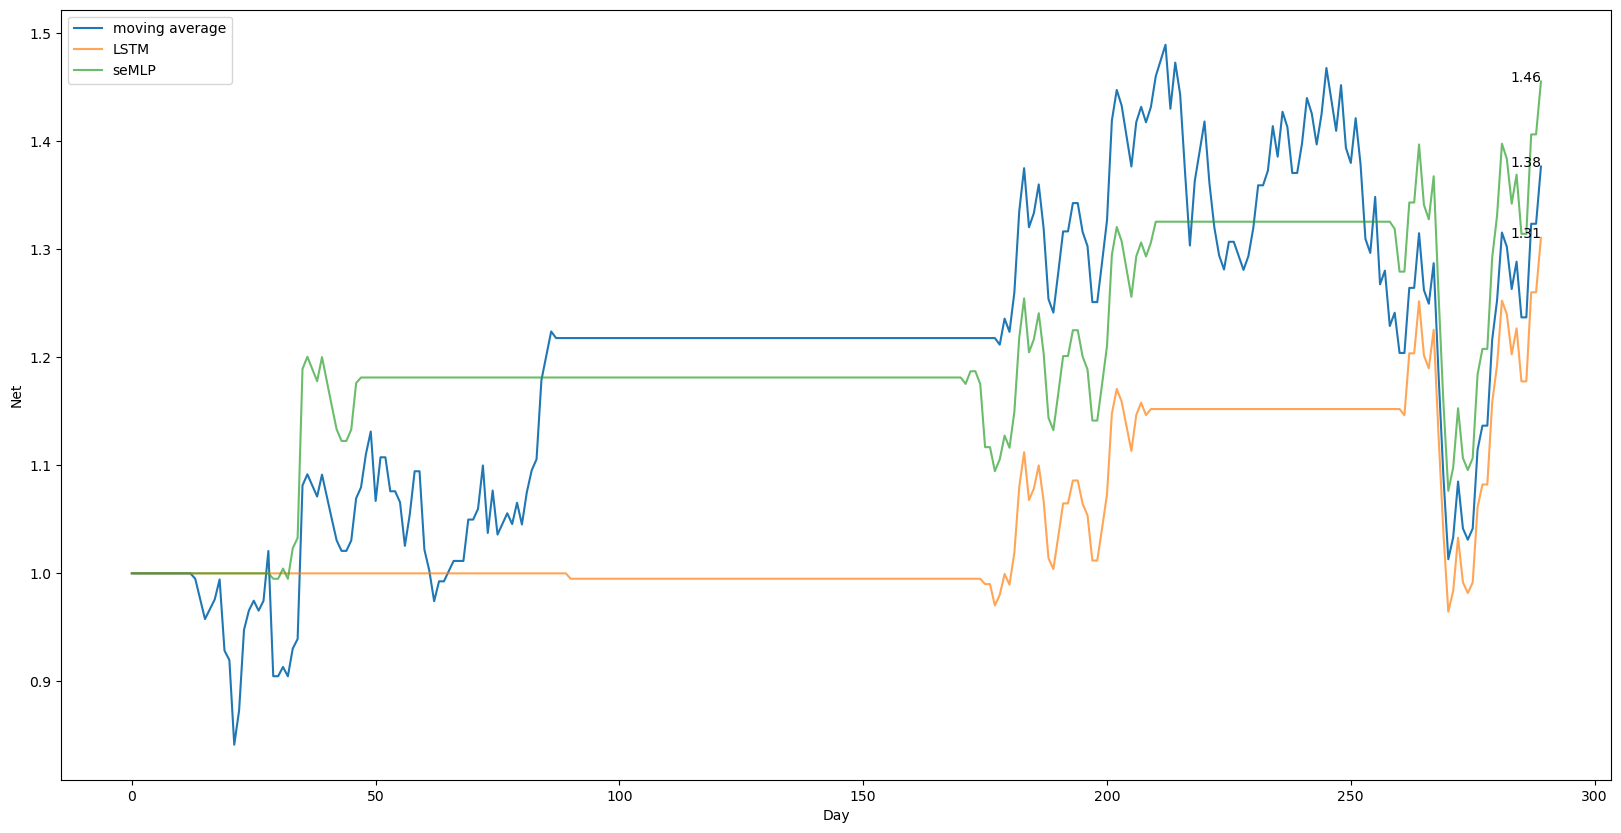

In [409]:
plt.figure(figsize = (20,10))
plt.plot(moving_income, label="moving average")
plt.plot(lstm_income, label="LSTM", alpha=0.7)
plt.plot(semlp_income, label="seMLP", alpha=0.7)
for var in (semlp_income, moving_income, lstm_income):
    plt.annotate(f'{var[-1]:.2f}', (len(var)-1, var[-1]), ha='right')
plt.xlabel('Day')
plt.ylabel('Net')
plt.legend()
plt.show()

## Further Improvement

### LSTM + seMLP

In [323]:
import torch.nn as nn
import torch
import numpy as np


class LSTMLP(nn.Module):
    def __init__(self, in_features, out_features, layers, hidden_size, num_stacked_layers, activation='relu', prune_percentile=0.0):
        super().__init__()

        self.num_stacked_layers = num_stacked_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(in_features, hidden_size, num_stacked_layers,
                            batch_first=True)

        # Create the linear layers
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.num_layer = len(layers)+1
        layer_nodes = layers
        layers_in_out = np.zeros((self.num_layer, 2))
        layers_in_out[0][0] = hidden_size # lstm hidden
        layers_in_out[len(layers)][1] = out_features
        for i in range(len(layers)):
            layers_in_out[i][1] = layers_in_out[i+1][0] = layer_nodes[i]
        self.linears = torch.nn.ModuleList()
        for i in range(self.num_layer):
            self.linears.append(torch.nn.Linear(int(layers_in_out[i][0]), int(layers_in_out[i][1])))

        # Choose the activation function
        if activation == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = torch.nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        else:
            raise ValueError(f'Unknown activation function: {activation}')

        self.out_activation = torch.nn.Tanh()

        # Initialize the weights and biases
        for linear in self.linears:
            torch.nn.init.xavier_normal_(linear.weight)
            torch.nn.init.zeros_(linear.bias)

        self.prune_percentile = prune_percentile

    def forward(self, x):

        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        x = x.unsqueeze(1)
        x, _ = self.lstm(x, (h0, c0))

        for i, linear in enumerate(self.linears):
            x = linear(x.to(self.device))
            if i < len(self.linears)-1:
                x = self.activation(x)
            # else:
            #     x = self.out_activation(x)

        return x

In [324]:
lstm_mlp = LSTMLP(window-1, 1, semlp.GA.winner().get_layers(), 30, 2, activation='relu')
learning_rate = 0.001
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstmlp_training_loss, lstmlp_test_loss = train(lstm_mlp, criterion, optimizer, training_loader, testing_loader)

C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
C:\Users\jeffl\anaconda3\envs\ML\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


In [325]:
# plot_loss(lstmlp_training_loss, lstmlp_test_loss)

In [326]:
# plot_prediction(lstm_mlp)